In [378]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import qqplot
import numpy as np
from math import isnan
from itertools import chain
plt.style.use('seaborn')

# Demographics

In [729]:
demo = pd.read_csv("pilot2/demographic.csv")
demo.groupby('Sex').describe()

time_taken                                               \
                       count           mean            std            min   
Sex                                                                         
CONSENT REVOKED          6.0  421848.294912     311.791325  421212.583621   
Female                  30.0     665.947700     237.471779     429.789000   
Male                    21.0   41043.519236  126615.202030     432.682000   
Prefer not to say        1.0     511.828000            NaN     511.828000   

                                                                               \
                             25%            50%            75%            max   
Sex                                                                             
CONSENT REVOKED    421954.126353  421976.049722  421985.175309  421990.050673   
Female                512.226000     566.037500     787.128500    1158.538000   
Male                  551.540000     699.272000    1430.268000  421940.725788   
Prefer not to say     511.828000     511.828000     511.828000     511.828000   

                    age             ... num_rejections      prolific_score  \
                  count       mean  ...            75%  max          count   
Sex                                 ...                                      
CONSENT REVOKED     6.0  21.500000  ...            0.0  1.0            6.0   
Female             30.0  24.766667  ...            1.0  3.0           30.0   
Male               21.0  25.714286  ...            1.0  5.0           21.0   
Prefer not to say   1.0  22.000000  ...            0.0  0.0            1.0   

                                                                            
                         mean       std    min    25%    50%    75%    max  
Sex                                                                         
CONSENT REVOKED     99.833333  0.408248   99.0  100.0  100.0  100.0  100.0  
Female              99.166667  1.876963   92.0   99.0  100.0  100.0  100.0  
Male                99.285714  1.454058   94.0   99.0  100.0  100.0  100.0  
Prefer not to say  100.000000       NaN  100.0  100.0  100.0  100.0  100.0  

[4 rows x 40 columns]

In [732]:
demo.age.mean()

24.724137931034484

In [733]:
demo.groupby('Country of Birth').describe()

time_taken                 \
                                                  count           mean   
Country of Birth                                                         
Belgium                                             1.0     551.540000   
CONSENT REVOKED                                     6.0  421848.294912   
Chile                                               1.0     776.265000   
Czech Republic                                      1.0     429.789000   
DATA EXPIRED                                        1.0     998.605000   
France                                              1.0     431.860000   
Hungary                                             2.0    1368.061500   
Italy                                               5.0     642.417200   
Lebanon                                             1.0     511.828000   
Mexico                                             10.0     772.079400   
Netherlands                                         1.0     699.272000   
Poland                                              7.0     970.622000   
Portugal                                           12.0   35814.438514   
South Africa                                        2.0     867.948000   
South Georgia and the South Sandwich Islands        1.0    1377.703000   
Spain                                               3.0     543.370000   
United Kingdom                                      3.0  141008.225263   

                                                                            \
                                                        std            min   
Country of Birth                                                             
Belgium                                                 NaN     551.540000   
CONSENT REVOKED                                  311.791325  421212.583621   
Chile                                                   NaN     776.265000   
Czech Republic                                          NaN     429.789000   
DATA EXPIRED                                            NaN     998.605000   
France                                                  NaN     431.860000   
Hungary                                         1254.816845     480.772000   
Italy                                            233.321735     431.903000   
Lebanon                                                 NaN     511.828000   
Mexico                                           240.871038     432.682000   
Netherlands                                             NaN     699.272000   
Poland                                           800.372868     465.242000   
Portugal                                      121565.814338     439.787000   
South Africa                                     400.444470     584.791000   
South Georgia and the South Sandwich Islands            NaN    1377.703000   
Spain                                             18.122935     524.115000   
United Kingdom                                243294.682531     529.358000   

                                                                            \
                                                        25%            50%   
Country of Birth                                                             
Belgium                                          551.540000     551.540000   
CONSENT REVOKED                               421954.126353  421976.049722   
Chile                                            776.265000     776.265000   
Czech Republic                                   429.789000     429.789000   
DATA EXPIRED                                     998.605000     998.605000   
France                                           431.860000     431.860000   
Hungary                                          924.416750    1368.061500   
Italy                                            509.545000     613.140000   
Lebanon                                          511.828000     511.828000   
Mexico                                           621.682500     781

In [379]:
data = pd.read_csv("pilot2/data.csv")
# Making sure the condition and responses are the same
data.condition = data.condition.apply(lambda x: x.lower())

In [380]:
def remove_participants(df):
    '''
    Remove participants that do not pass comprehension check
    in at most 3 tries
    '''
    limit = 3
    num_asks = 3
    threshold = limit*num_asks
    group = df.groupby(["subject_id"])
    subjs = list(group.attempts.count()[group.attempts.count() > threshold].index)
    return df[~df["subject_id"].isin(subjs)]

def drop_columns(df):
    '''
    Drop unused columns
    '''
    return df.drop(columns=["failed_video","failed_audio","failed_images",
                           "internal_node_id","timeout", "stimulus",
                            "study_id","session_id","success","attempts",
                           "trial_type","time_elapsed", "value"])

def adjust_trial_index(df):
    '''
    Reindex the 75 trial indices from [21-N] to [0-N]
    '''
    indices = list(range(75))
    df['trial_index'] = indices
    return df

In [424]:
# Dataframe containing only the trial responses
responses = data[data.task == 'response']
# Dropping columns
responses = drop_columns(responses)
# Reset index
responses = responses.reset_index(drop=True)
# Rename columns
responses = responses.rename(columns={'condition':'exp_condition',
                                     'response': 'response_'})
# Reindexing the trial indices from [21-N] to [0-N]
responses = responses.groupby('subject_id').apply(adjust_trial_index)
# Limiting response times to the timout max
responses.rt = responses.rt.apply(lambda x: 5000 if pd.isna(x) else x)
responses.rt = responses.rt.apply(lambda x: 5000 if x > 5000 else x)
# Z-Score RT
responses['zrt'] = (responses['rt'] - responses['rt'].mean())/responses['rt'].std(ddof=0)
# Taking the log(RT) and adding to dataframe
responses["log_rt"] = responses.rt.apply(lambda x: np.log(x))
# Z-score log RT
responses['zlogrt'] = (responses['log_rt'] - responses['log_rt'].mean())/responses['log_rt'].std(ddof=0)
# Adding per-trial condition (i.e. was the correct answer yes or no)
responses['trial_condition'] = responses.correct_response == responses.exp_condition
responses['trial_condition'] = responses.trial_condition.apply(lambda x: "Yes" if x else "No")
# Recoding the responses as "yes" or "no" instead of condition-dependent key
responses['response'] = responses.exp_condition == responses.response_
responses['response'] = responses.response.apply(lambda x: "Yes" if x else "No")
# Adding per-participant accuracy to the dataframe
responses['participant_accuracy'] = responses.groupby('subject_id')['correct'].transform('sum')/len(responses.groupby('trial_index'))
responses['trial_accuracy'] = responses.groupby('trial_index')['correct'].transform('sum')/len(responses.groupby('subject_id'))
responses['scene_accuracy'] = responses.groupby('scene')['correct'].transform('sum')/len(responses.groupby('subject_id'))
# Split scene conditions into simulation time and collision-no-collision
responses = pd.concat([responses, responses.scene.str.split("_", expand=True)],axis=1)
responses = responses.rename(columns={0:'sim_time',
                             1: 'collision'})
responses['collision'] = responses['collision'].str.replace('\d+', '')

<ipython-input-424-cb815ce98a68>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  responses['collision'] = responses['collision'].str.replace('\d+', '')


In [425]:
def compare(item1):
    '''
    Comparator for sorting scenes
    '''
    if item1[0] == 'l':
        return -1
    elif item1[0] == 'm':
        return 0
    else:
        return 1

# Gather scenes
scenes = list(responses.scene.unique())
# Sort them according to our comparison function
scenes.sort(reverse=False,key=compare)
# Create new index
index = list(range(len(scenes)))
# Create mapping from scenes to index
scene_index_map = {s:i for s,i in zip(scenes,index)}
# Create index in response dataframe
responses.scene_index = responses.scene.apply(lambda x: scene_index_map[x])

In [772]:
# Remove outliers
clean_responses = responses[abs(responses.zrt) <= 2]
clean_responses

,trial_index,subject_id,exp_condition,rt,response_,task,correct_response,correct,task_condition,scene,...,zrt,log_rt,zlogrt,trial_condition,response,participant_accuracy,trial_accuracy,scene_accuracy,sim_time,collision
0,0,6150ca3f37e1fe330f70311d,f,1493.0,j,response,j,True,No,med_no3,...,0.004348,7.308543,0.263467,No,No,0.826667,0.705882,0.921569,med,no
2,2,6150ca3f37e1fe330f70311d,f,1977.0,j,response,j,True,No,low_no7,...,0.582299,7.589336,0.848521,No,No,0.826667,0.823529,0.921569,low,no
4,4,6150ca3f37e1fe330f70311d,f,2462.0,j,response,j,True,No,high_no11,...,1.161445,7.808729,1.305644,No,No,0.826667,0.803922,0.647059,high,no
5,5,6150ca3f37e1fe330f70311d,f,2407.0,j,response,j,True,No,med_no8,...,1.095769,7.786136,1.258570,No,No,0.826667,0.823529,0.941176,med,no
6,6,6150ca3f37e1fe330f70311d,f,1706.0,j,response,j,True,No,low_no12,...,0.258694,7.441907,0.541341,No,No,0.826667,0.823529,0.960784,low,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,70,5eb3089b41a3810df6c8b078,j,929.0,f,response,f,True,No,med_no11,...,-0.669133,6.834109,-0.725052,No,No,0.733333,0.725490,0.745098,med,no
3821,71,5eb3089b41a3810df6c8b078,j,855.0,f,response,f,True,No,low_no8,...,-0.757498,6.751101,-0.898004,No,No,0.733333,0.686275,0.882353,low,no
3822,72,5eb3089b41a3810df6c8b078,j,788.0,f,response,f,True,No,high_no9,...,-0.837504,6.669498,-1.068031,No,No,0.733333,0.862745,0.941176,high,no
3823,73,5eb3089b41a3810df6c8b078,j,568.0,f,response,f,True,No,high_no6,...,-1.100209,6.342121,-1.750145,No,No,0.733333,0.803922,0.509804,high,no


In [774]:
# Bin according to how obvious the outcome is
obvious_scenes = [
    "high_yes4",
    "high_yes5",
    "high_yes6",
    "high_yes7",
    "high_yes8",
    "high_yes9",
    "high_yes11",
    "high_yes12",
    "high_yes14",
    "med_yes0",
    "med_yes1",
    "med_yes2",
    "med_yes3",
    "med_yes4",
    "med_yes5",
    "med_yes6",
    "med_yes7",
    "med_yes8",
    "med_yes9",
    "med_yes10",
    "med_yes11",
    "med_yes12",
    "med_yes13",
    "med_yes14"
]

clean_responses['obvious'] = clean_responses['scene'].isin(obvious_scenes)

<ipython-input-774-3bfd1d600eeb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_responses['obvious'] = clean_responses['scene'].isin(obvious_scenes)


# Plots

In [648]:
sns.set_style("whitegrid")
sns.set_palette("bone_r")

## Accuracy Per Collision Condition
Did accuracy change according to whether the ball was going to collide with the goal or not?

#### Conclusions
1. Accuracy is not normally-distributed for either collision condition (Shapiro, p < 8e-43)
2. Accuracy for No-Collision condition is significantly higher than for Yes-Collision condition (MWU, p = 0.009)

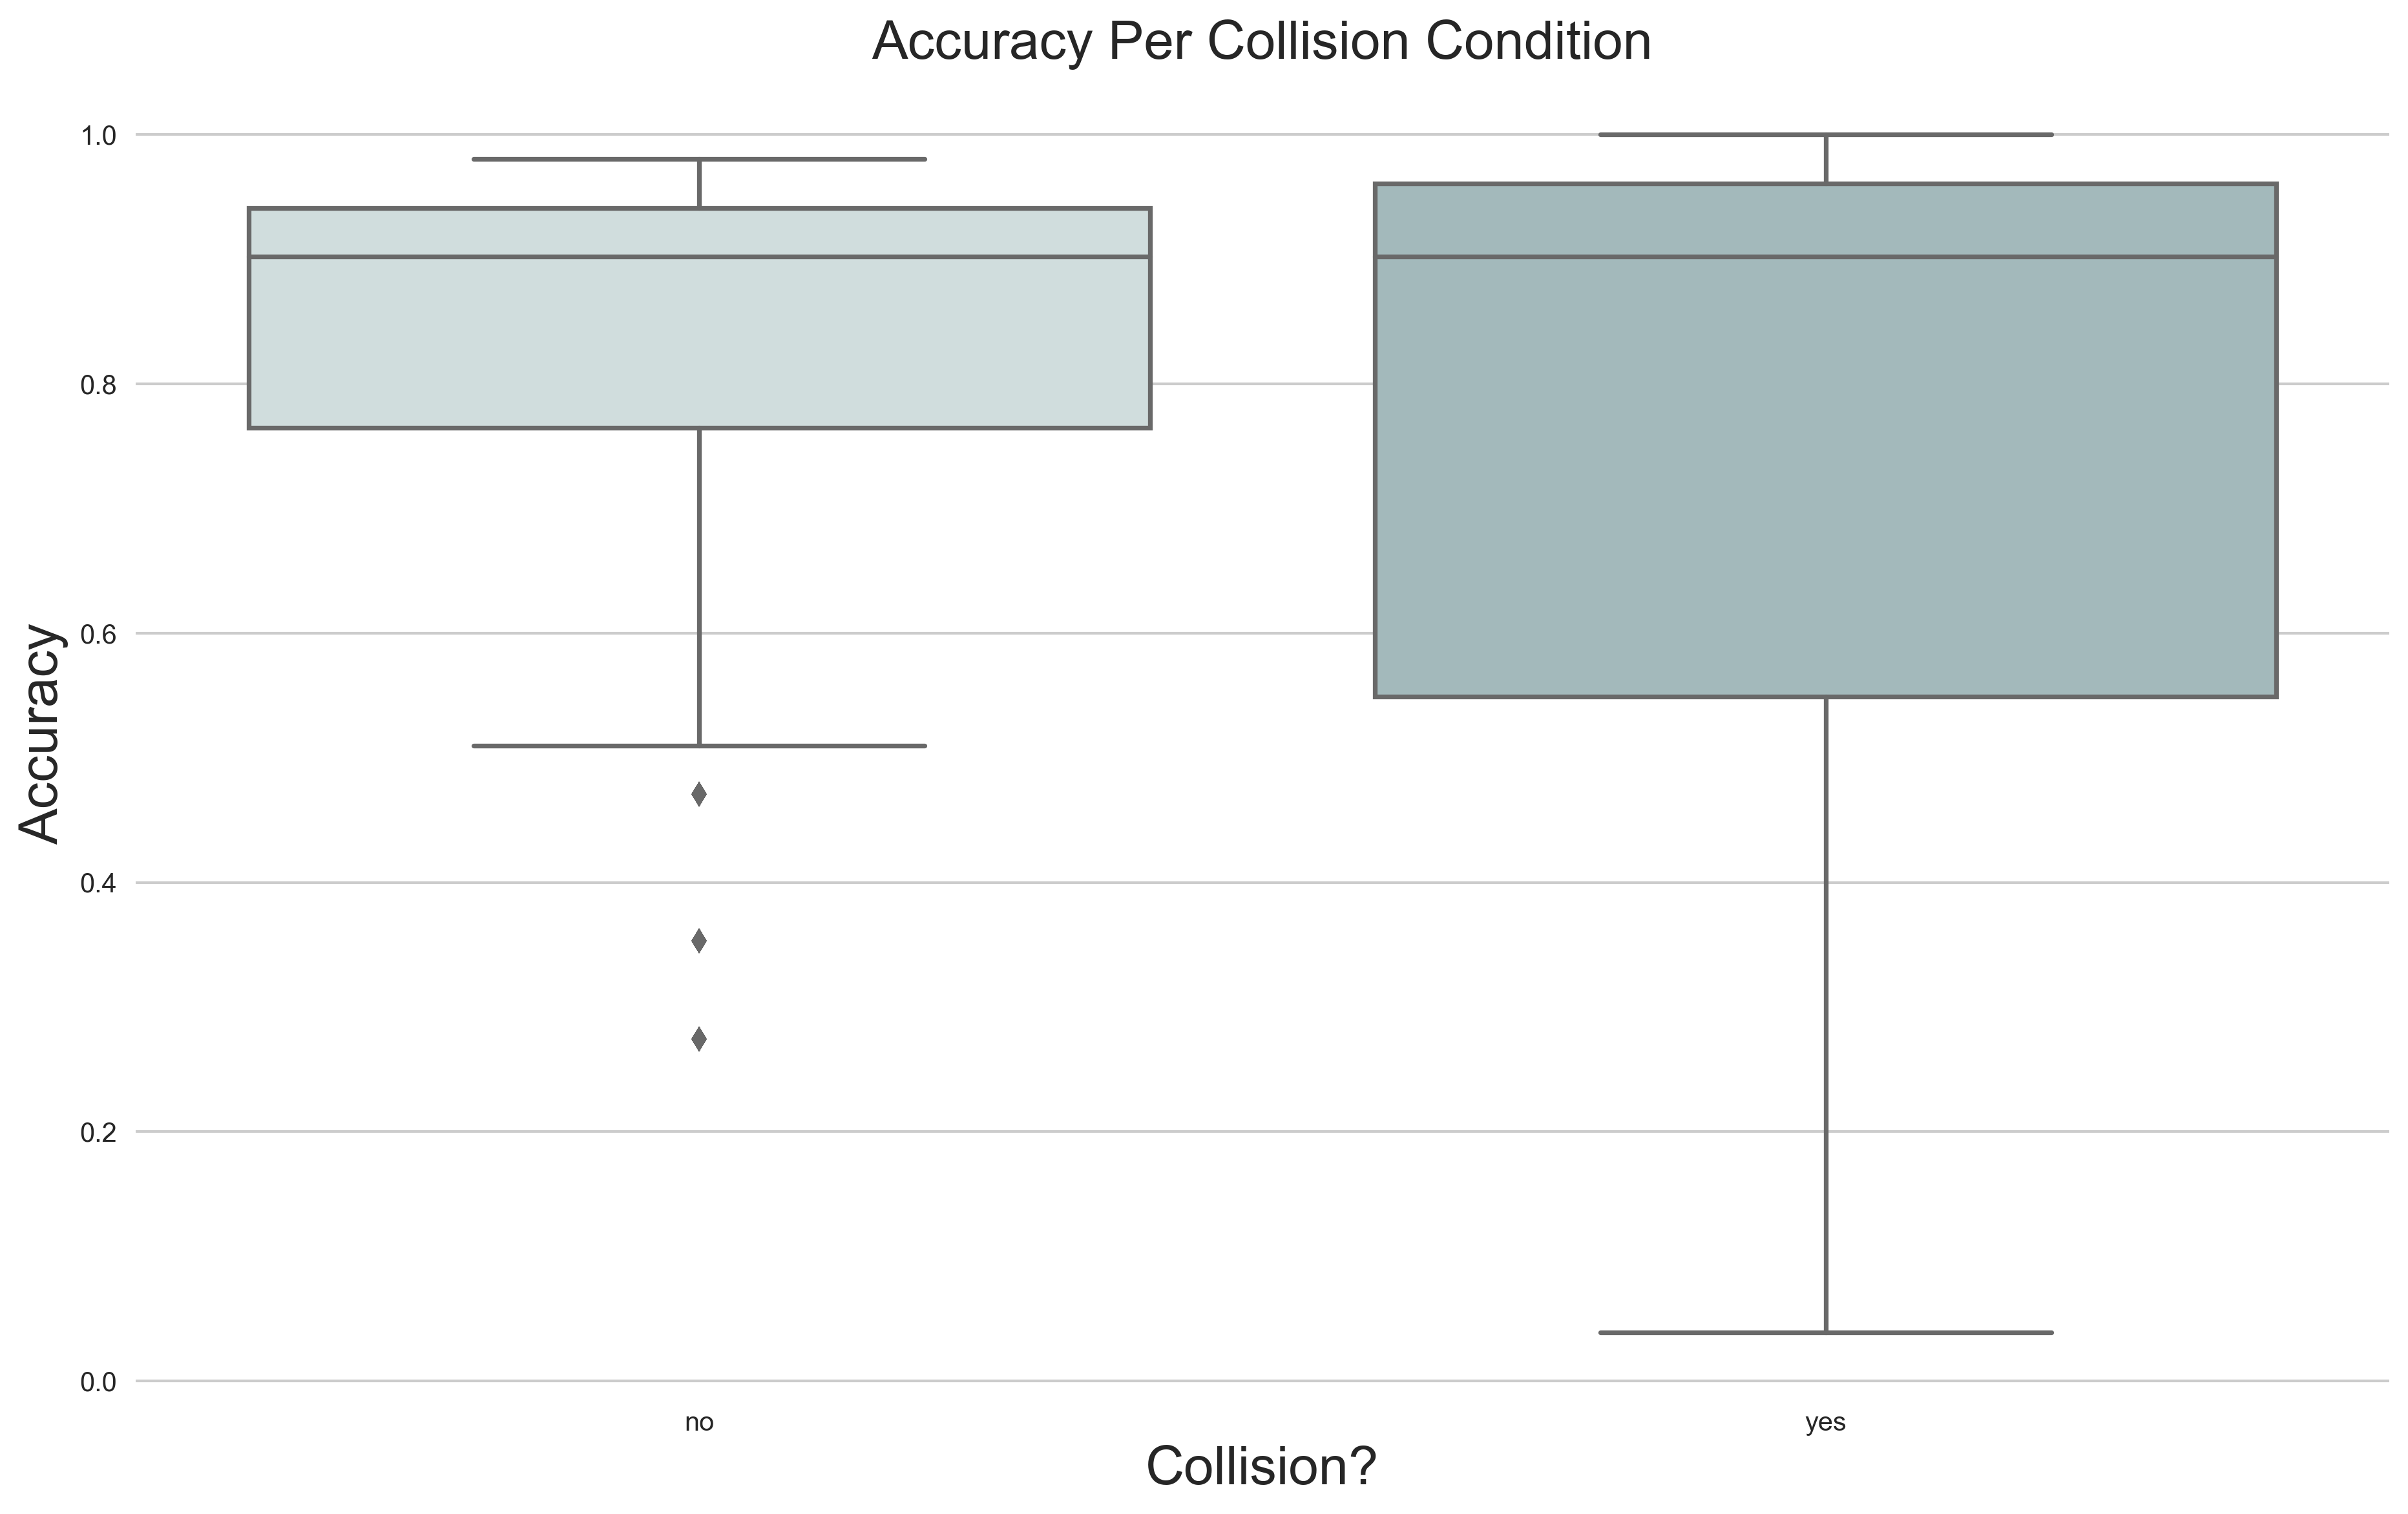

In [737]:
trial=clean_responses.groupby("trial_condition").scene_accuracy.apply(list)
figure(figsize=(15, 9), dpi=300)

sns.boxplot(y="scene_accuracy",x="collision",data=clean_responses)
# plt.xticks(rotation = 90)
plt.title("Accuracy Per Collision Condition",fontsize=20)
# plt.ylim(0,1)
# plt.xticks([1,2],[trial.index[0],trial.index[1]])
plt.xlabel("Collision?",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
# plt.tight_layout()
plt.show()

In [595]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

no = list(clean_responses[(clean_responses["collision"]=="no")].scene_accuracy)
yes = list(clean_responses[(clean_responses["collision"]=="yes")].scene_accuracy)

shap_yes = shapiro(yes)
shap_no = shapiro(no)

print(f"Yes Shapiro: {shap_yes}. Data is {'not' if shap_yes.pvalue < 0.05 else ''} normal.")
print(f"No Shapiro: {shap_no}. Data is {'not' if shap_no.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(no, yes, alternative="greater")


print(f"No-Yes U test statistic: {u_res}")

Yes Shapiro: ShapiroResult(statistic=0.7452147006988525, pvalue=8.211609000943428e-43). Data is not normal.
No Shapiro: ShapiroResult(statistic=0.7646719813346863, pvalue=0.0). Data is not normal.

No-Yes U test statistic: MannwhitneyuResult(statistic=1655965.0, pvalue=0.009871820615582108)


## Accuracy Per Simulation Condition
Did accuracy change according to simulation time?

#### Conclusions
1. Accuracy is not normally distributed across simulation-time conditions (Shapiro, p < 2e-28)
2. Accuracy is significantly higher in Low condition than Med condition (MWU, p=7e-11)
3. Accuracy is significantly higher in Med condition than High condition (MWU, p=2e-96)
4. Accuracy is significantly higher in Low condition than High condition (MWU, p=2e-132)

Text(0, 0.5, 'Accuracy')

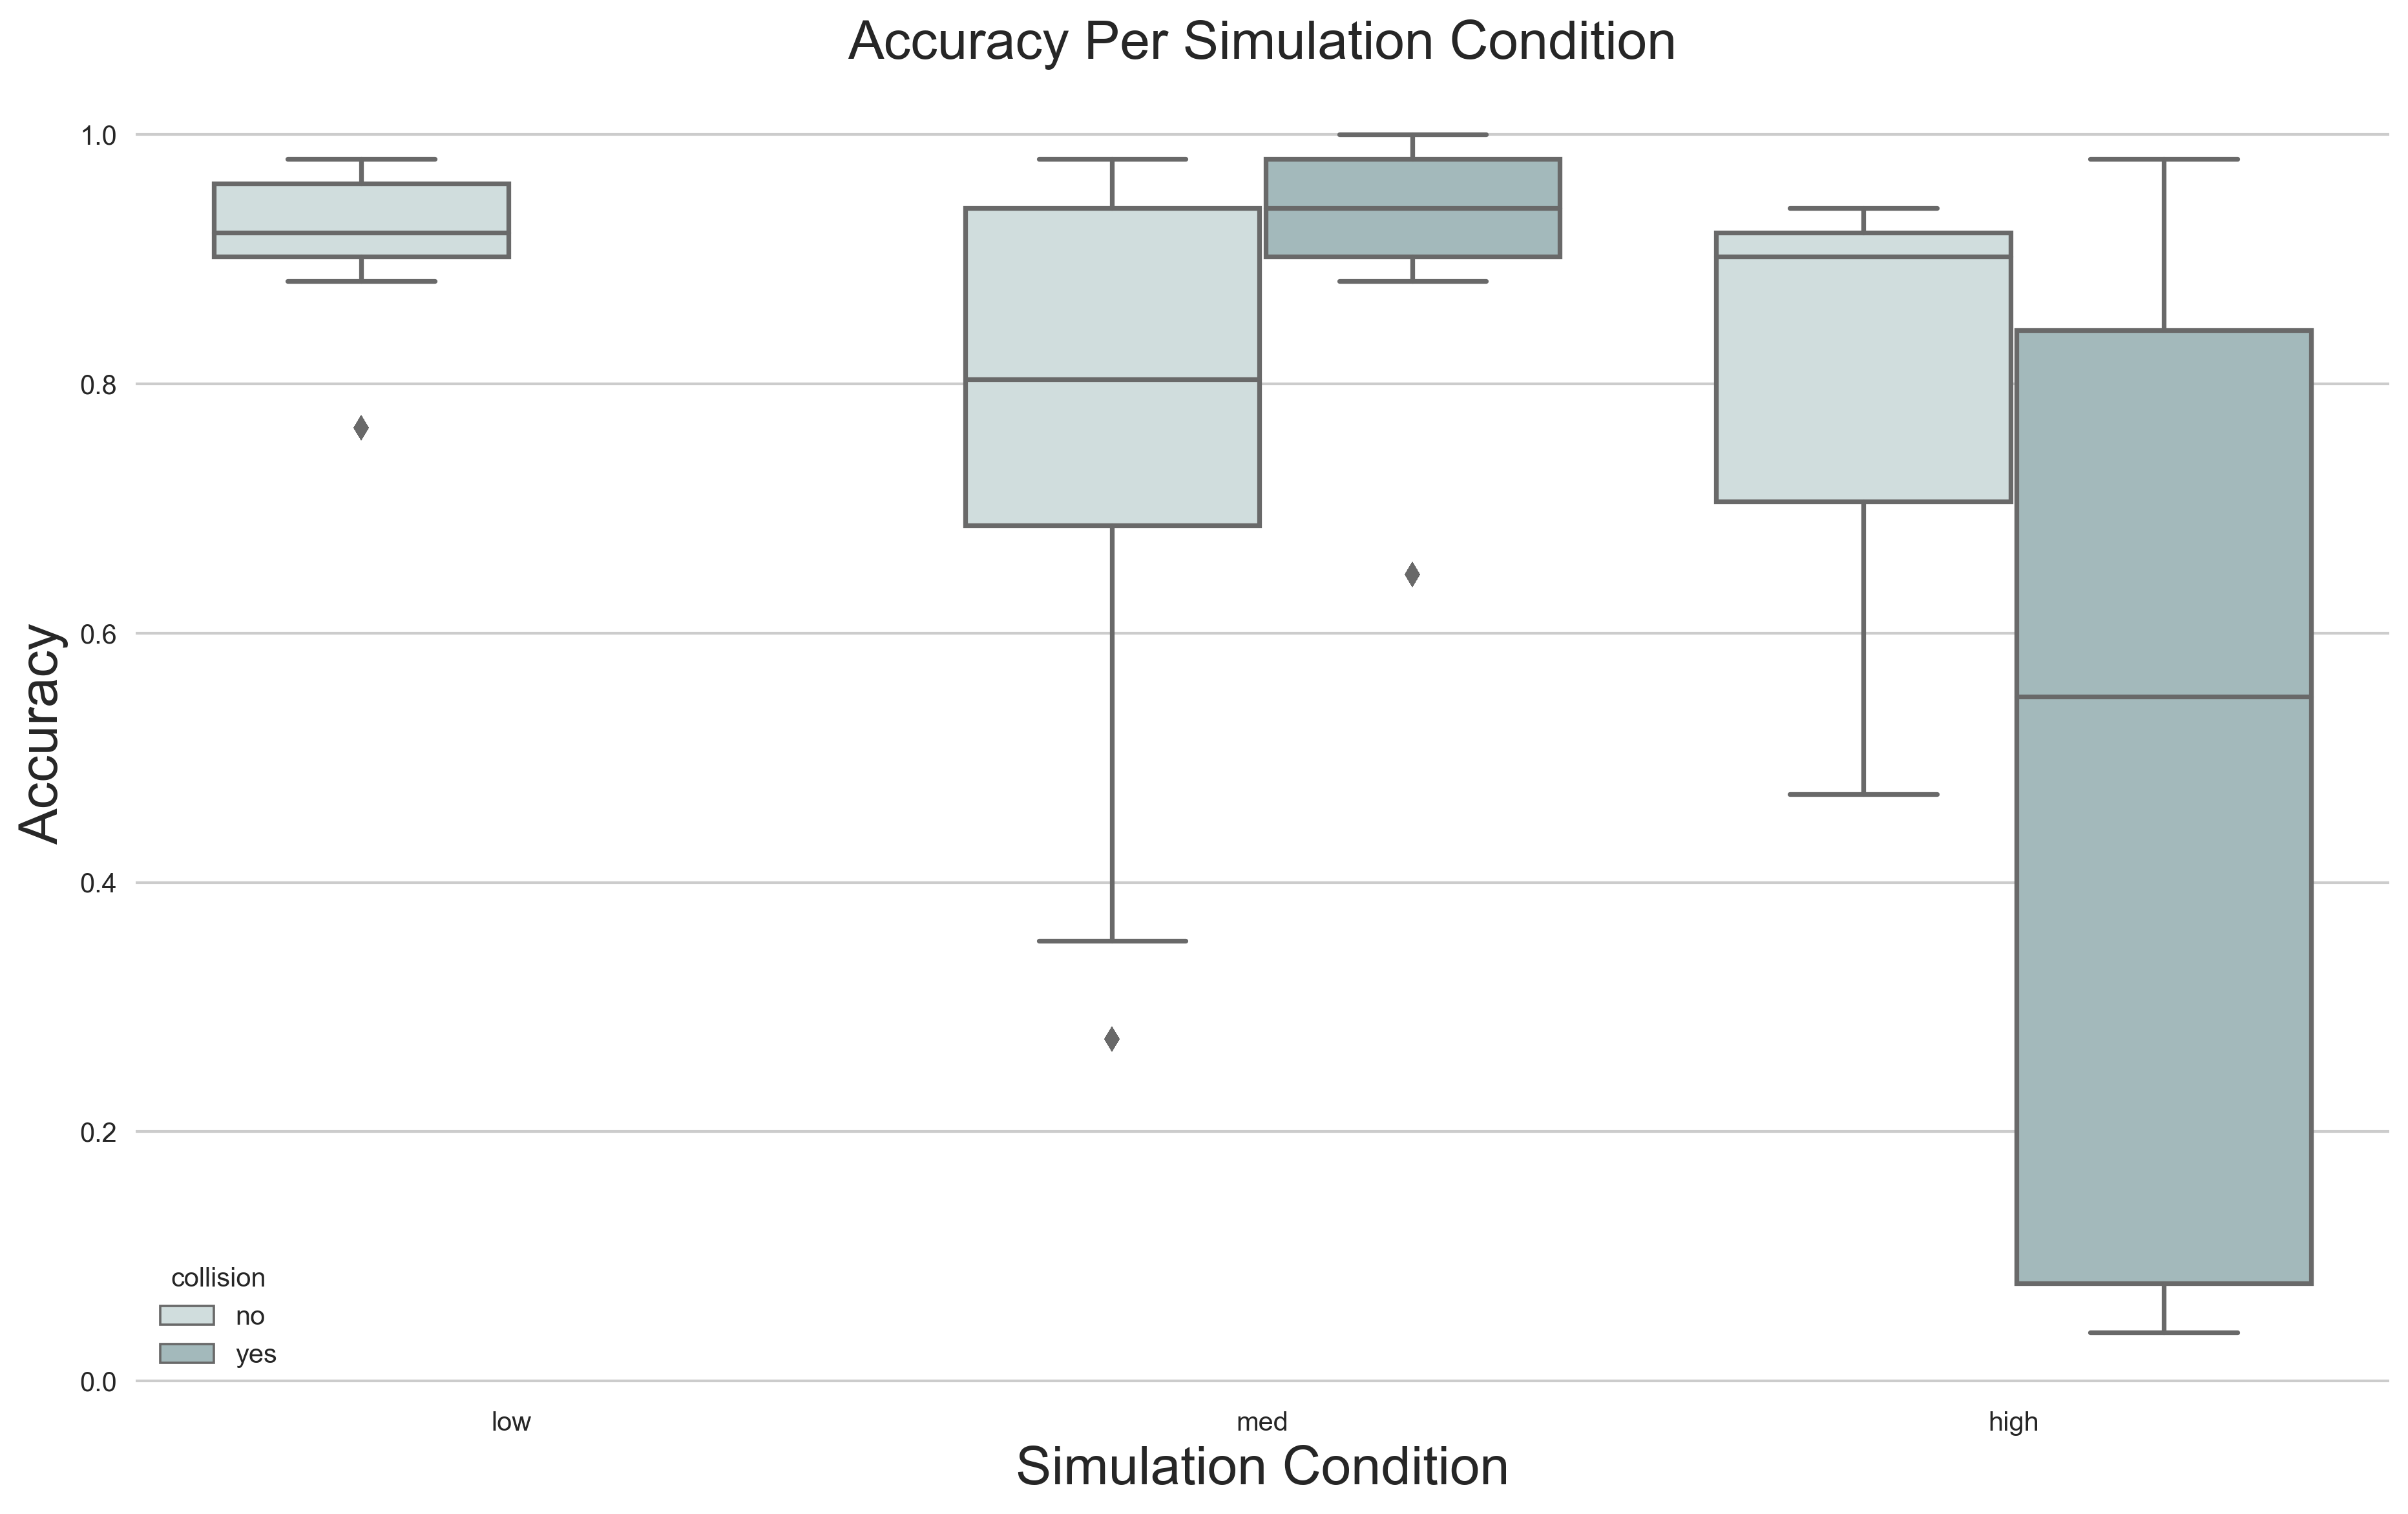

In [757]:
import seaborn as sns
custom_dict = {'low':0, 'med':1,'high':2}
trial=pd.DataFrame(clean_responses.groupby("sim_time").scene_accuracy.apply(list))
trial = trial.sort_values(by=['sim_time'],key=lambda x: x.map(custom_dict))

figure(figsize=(15, 9), dpi=300)

sns.boxplot(x="sim_time", y="scene_accuracy",data=clean_responses,order=['low','med','high'],hue="collision")
# plt.xticks(rotation = 90)
plt.title("Accuracy Per Simulation Condition",fontsize=20)
# plt.xticks([1,2,3],[trial.index[0],trial.index[1],trial.index[2]])
plt.xlabel("Simulation Condition",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
# plt.tight_layout()
# plt.show()

In [519]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].scene_accuracy)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].scene_accuracy)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].scene_accuracy)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: {shap_low}. Data is {'not' if shap_low.pvalue < 0.05 else ''} normal.")
print(f"Med Shapiro: {shap_med}. Data is {'not' if shap_med.pvalue < 0.05 else ''} normal.")
print(f"High Shapiro: {shap_high}. Data is {'not' if shap_high.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(low, med, alternative="greater")
u_res_mh = mannwhitneyu(med, high, alternative="greater")
u_res_lh = mannwhitneyu(low, high, alternative="greater")

print(f"Low-Med T test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: ShapiroResult(statistic=0.8088759779930115, pvalue=2.4079540982809037e-28). Data is not normal.
Med Shapiro: ShapiroResult(statistic=0.7384810447692871, pvalue=3.3210773604498165e-43). Data is not normal.
High Shapiro: ShapiroResult(statistic=0.8251177668571472, pvalue=7.52115628903071e-37). Data is not normal.

Low-Med T test statistic: MannwhitneyuResult(statistic=620405.0, pvalue=7.655273431818594e-11)
Med-High U test statistic: MannwhitneyuResult(statistic=1520305.0, pvalue=2.1920125587096735e-96)
Low-High U test statistic: MannwhitneyuResult(statistic=844969.5, pvalue=2.6186214279875002e-132)


In [758]:
high_no = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "no")].scene_accuracy)
high_yes = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses["collision"] == "yes")].scene_accuracy)

u_res = mannwhitneyu(high_yes, high_no, alternative="less")

print(f"High-Yes High-No U test statistic: {u_res}")

High-Yes High-No U test statistic: MannwhitneyuResult(statistic=136768.0, pvalue=2.552271028879357e-52)


## RT Per Simulation Condition
Did RT change according to simulation time?

### Boxplot

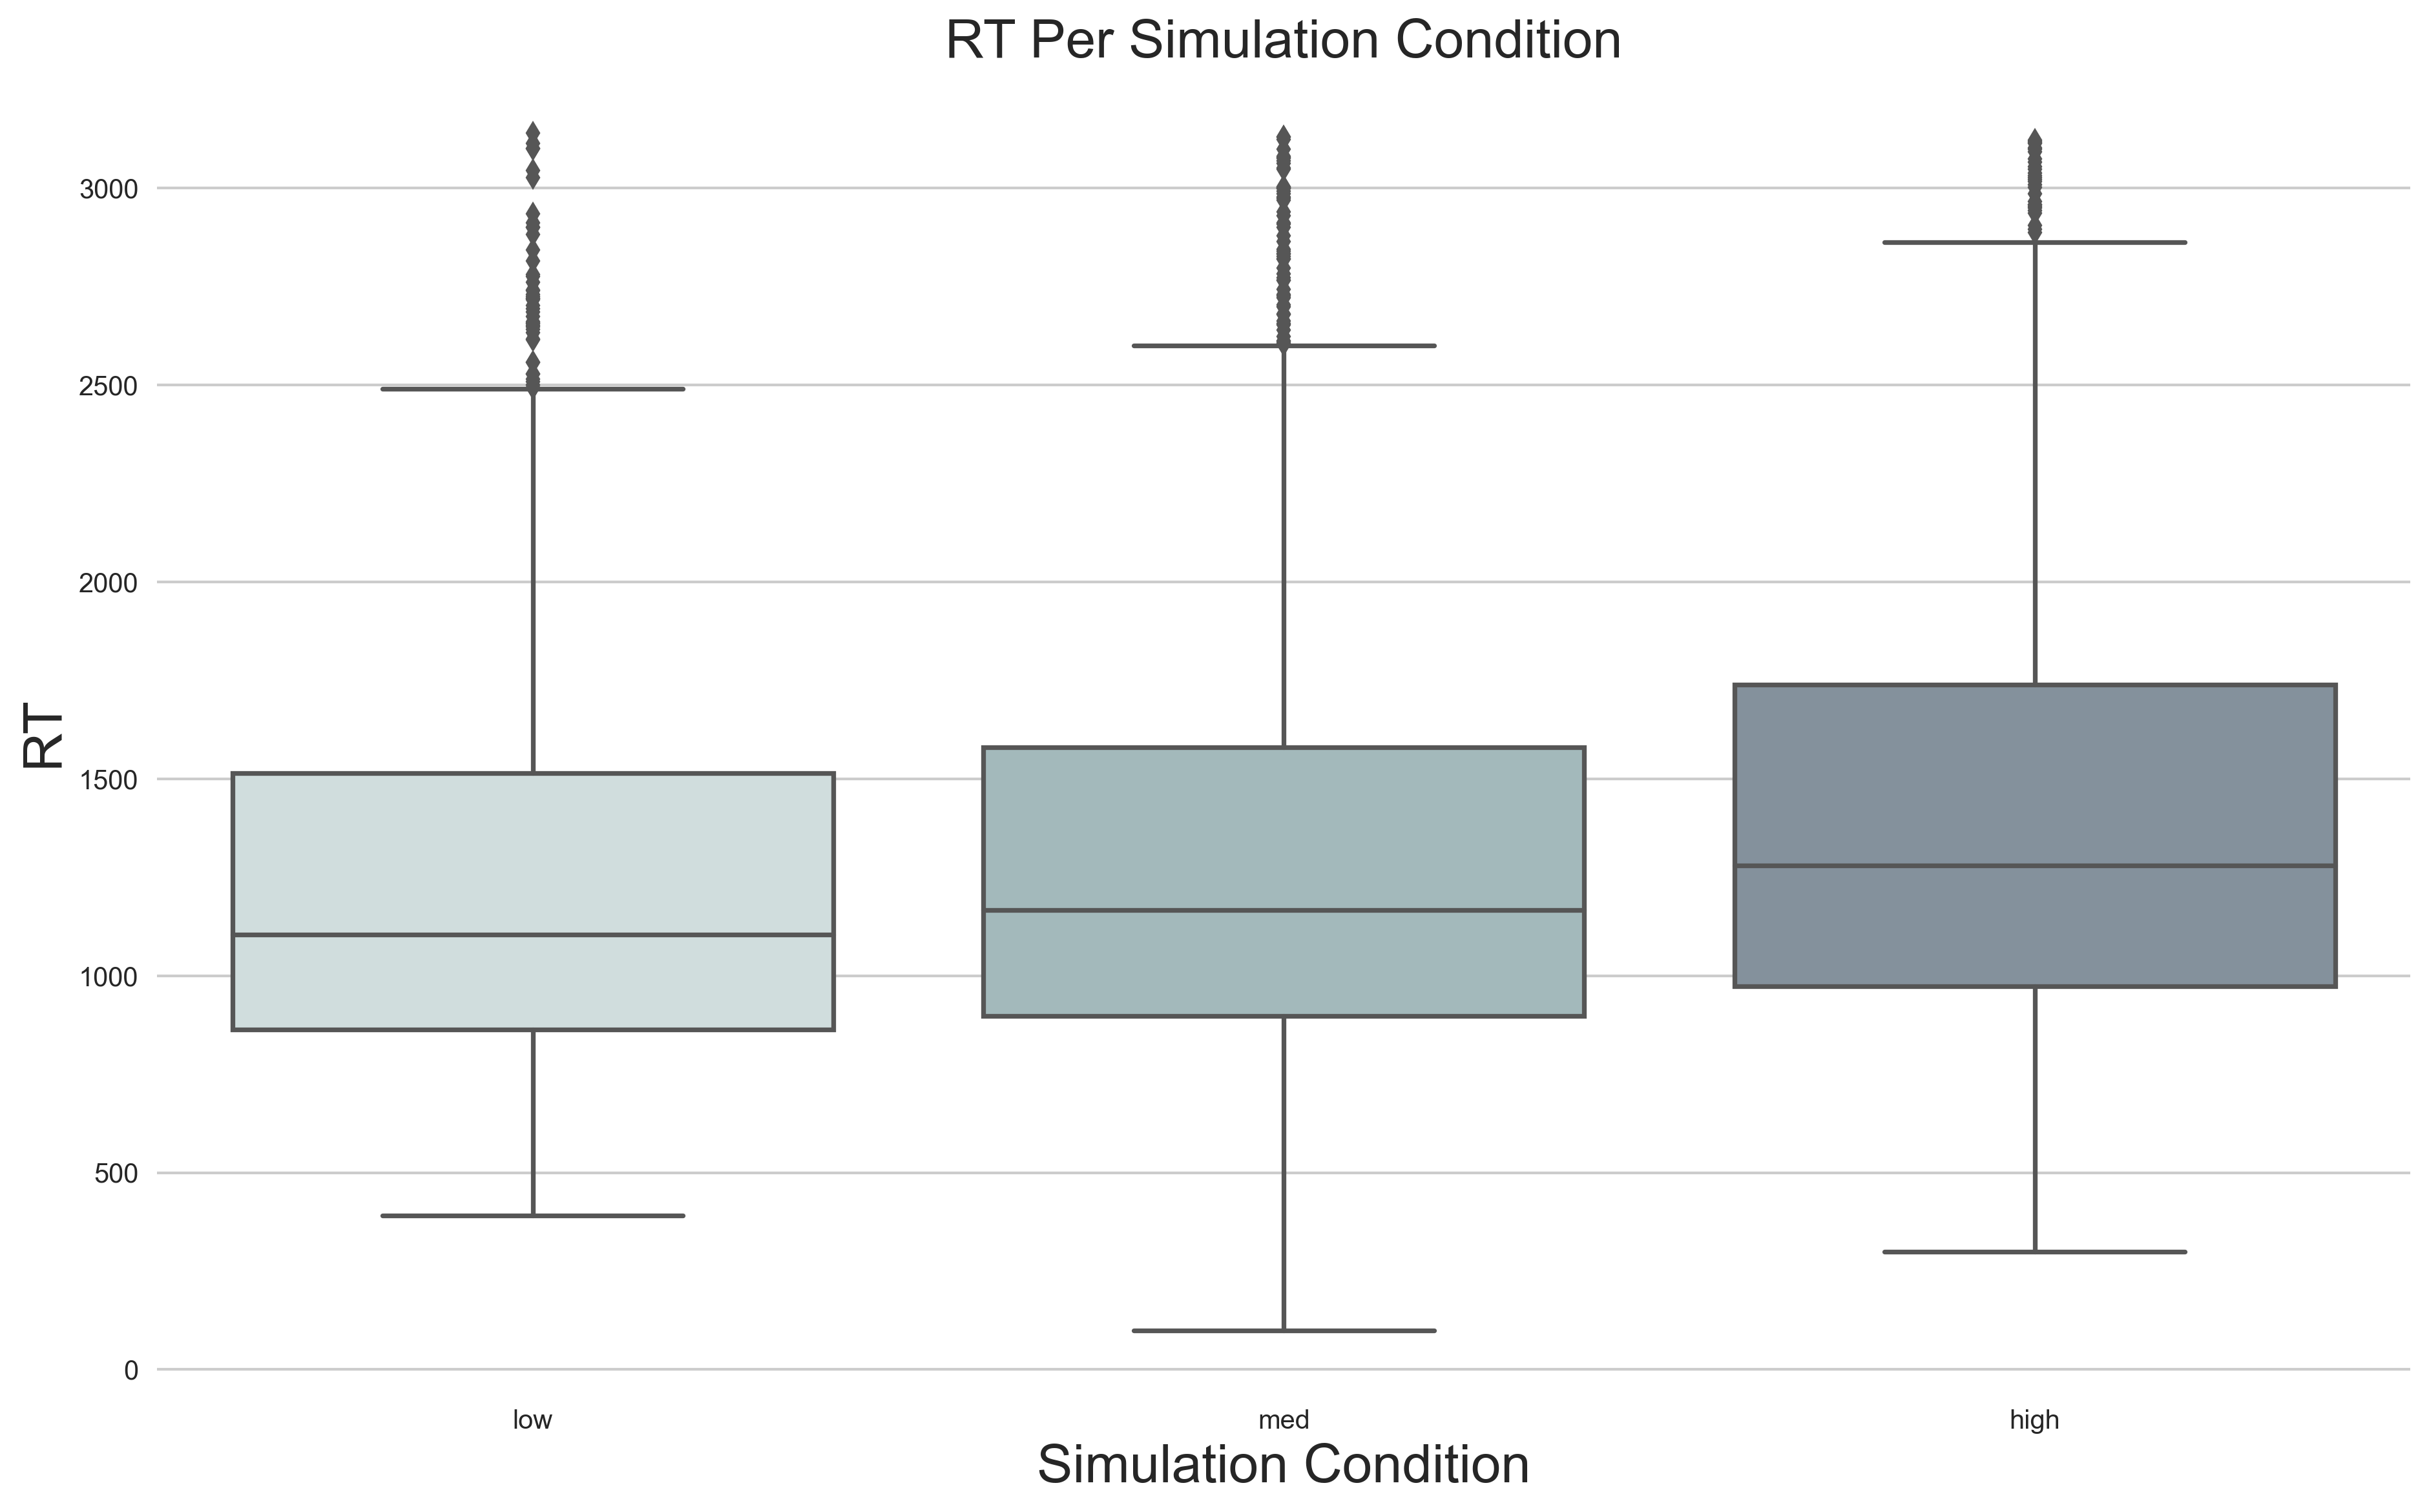

In [735]:
custom_dict = {'low':0, 'med':1,'high':2}
trial=pd.DataFrame(clean_responses.groupby("sim_time").zrt.apply(list))
trial = trial.sort_values(by=['sim_time'],key=lambda x: x.map(custom_dict))

figure(figsize=(15, 9), dpi=300)

# plt.boxplot(trial.zrt)
sns.boxplot(x="sim_time",y="rt",data=clean_responses,order=['low','med','high'])
# plt.xticks(rotation = 90)
plt.title("RT Per Simulation Condition",fontsize=20)
# plt.xticks([1,2,3],[trial.index[0],trial.index[1],trial.index[2]])
plt.xlabel("Simulation Condition",fontsize=20)
plt.ylabel("RT",fontsize=20)
# plt.tight_layout()
plt.show()

### Histogram

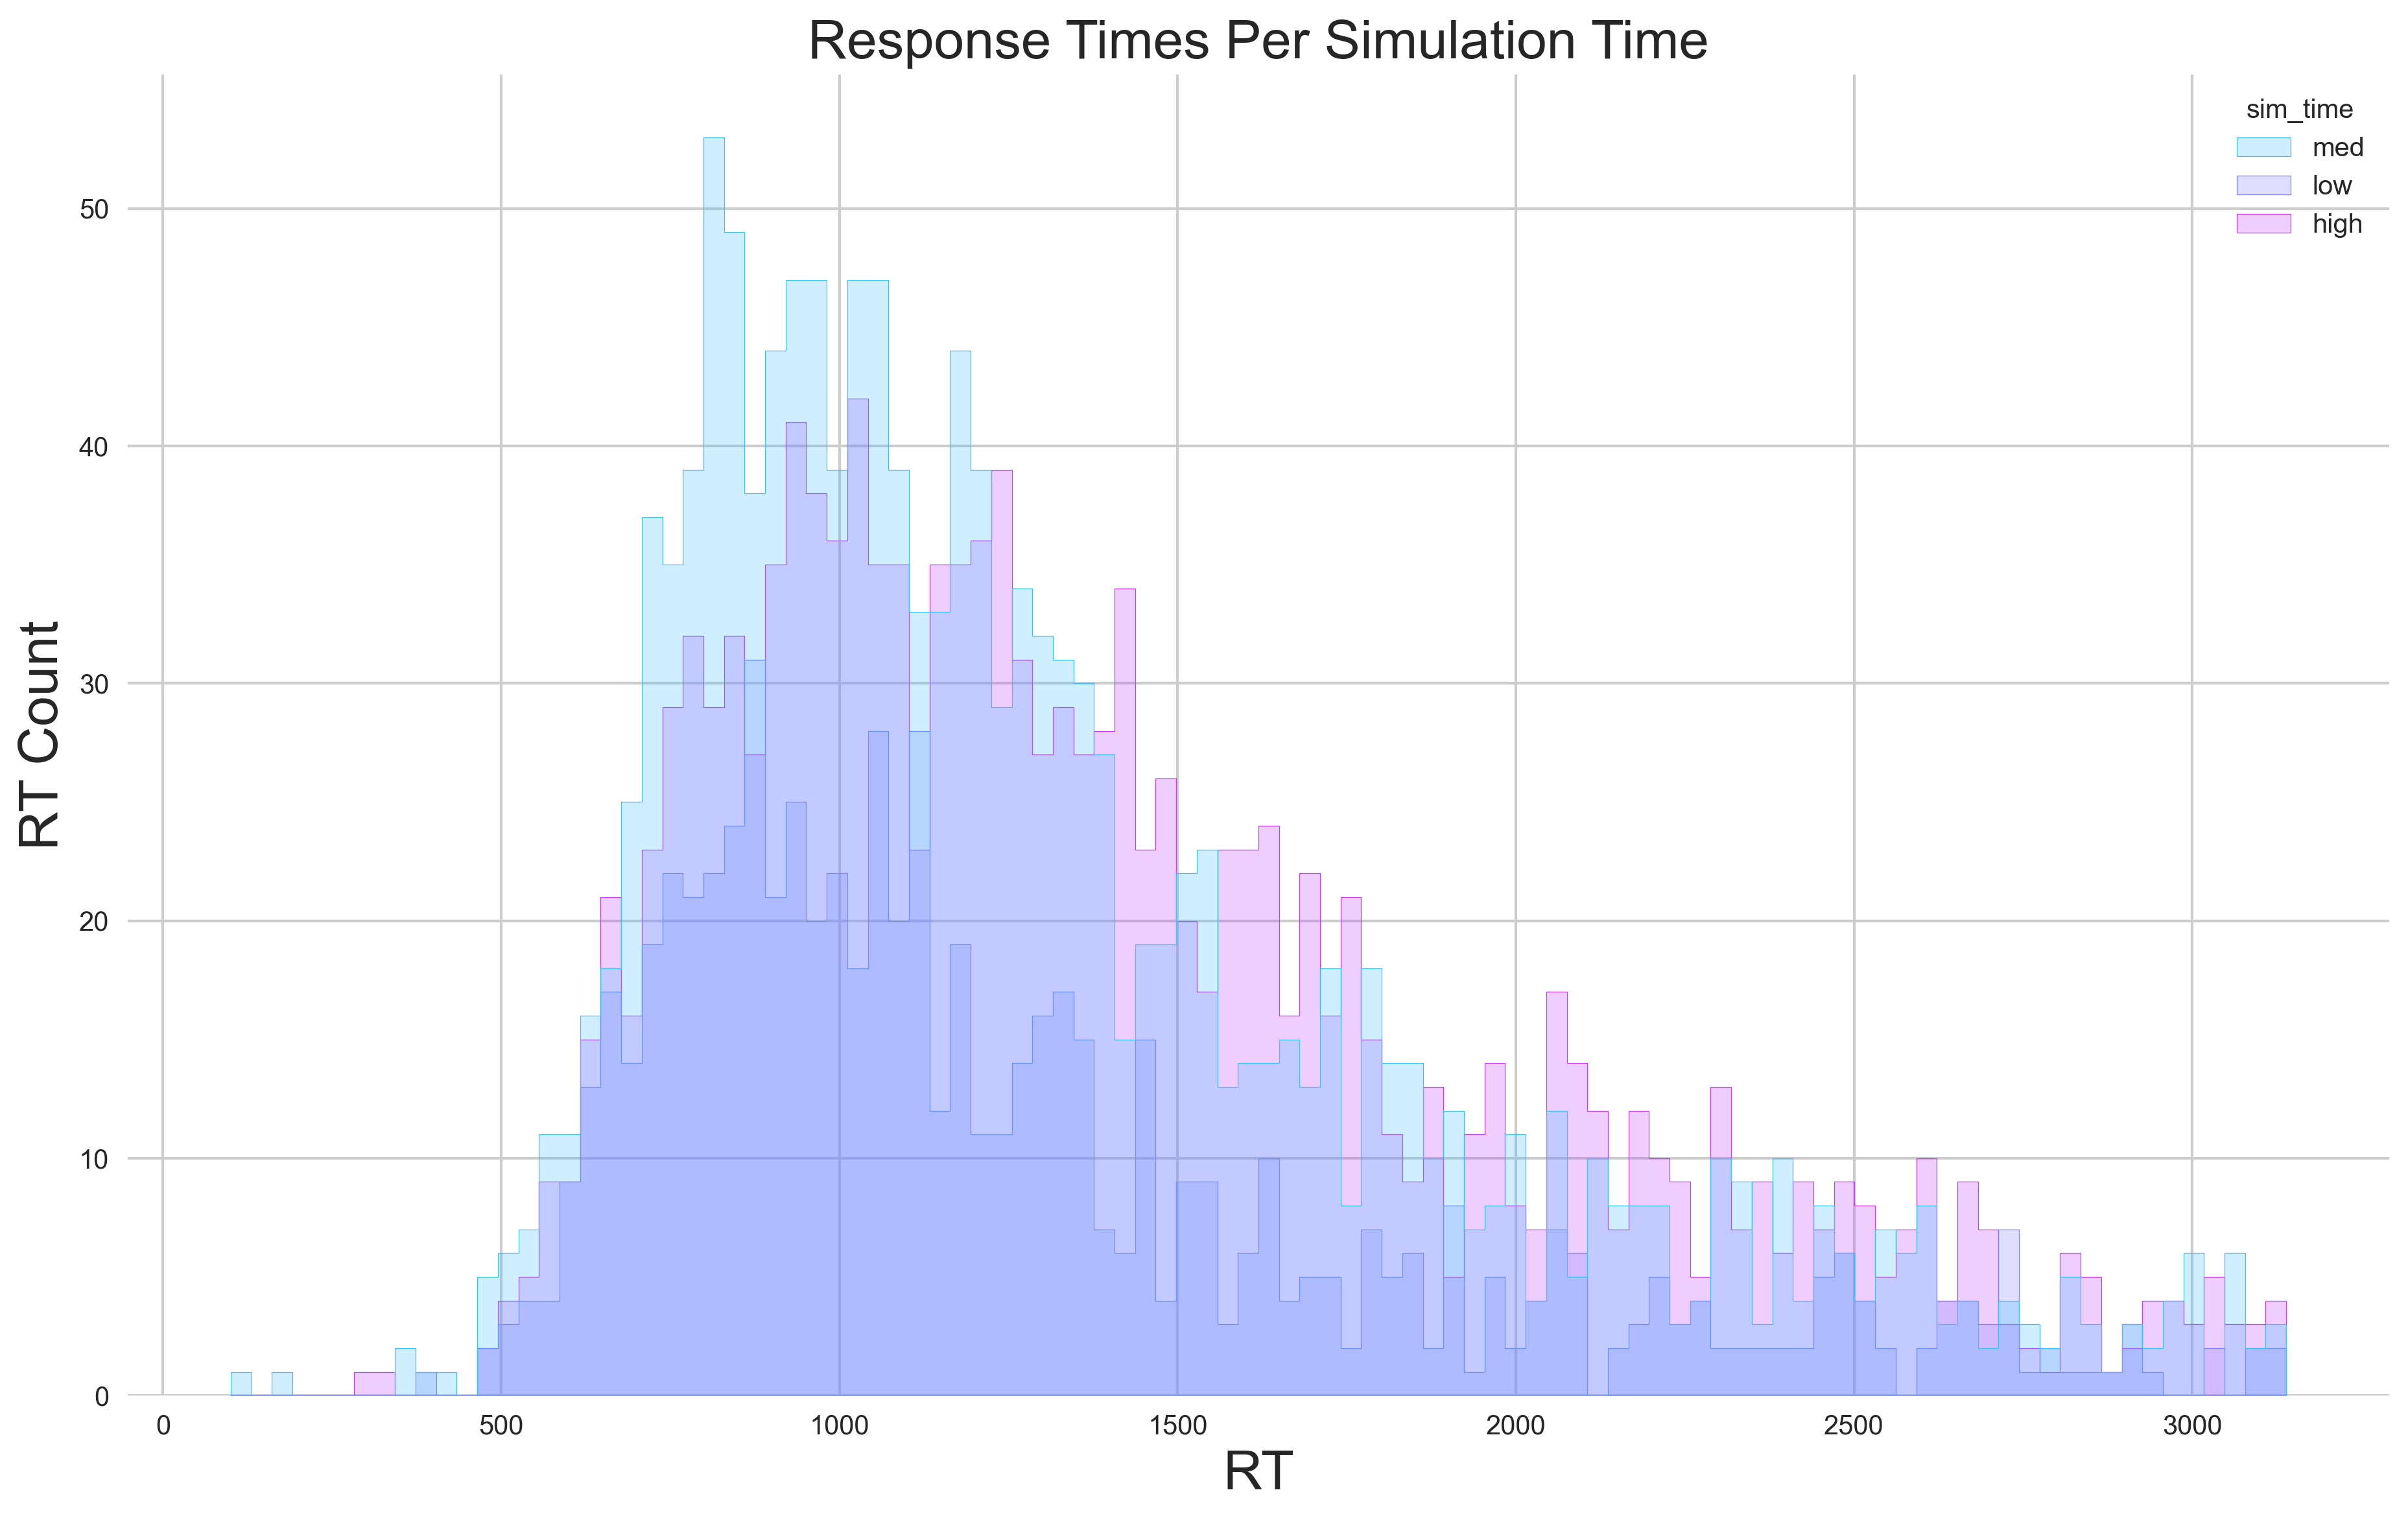

In [736]:
figure(figsize=(15, 9), dpi=300)

sns.histplot(x="rt", data=clean_responses, bins=100,hue="sim_time",element="step",palette="cool");
# sns.histplot(x="rt", data=clean_responses[clean_responses.sim_time=="med"], bins=100, label="Med");
# sns.histplot(x="rt", data=clean_responses[clean_responses.sim_time=="high"], bins=100, label="High");
# plt.hist(clean_responses[clean_responses.sim_time=="high"].rt, bins=100, label="High");
# plt.hist(clean_responses[clean_responses.sim_time=="low"].rt, bins=100, label="Low");
plt.title("Response Times Per Simulation Time",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("RT Count",fontsize=20);
# plt.axvline(clean_responses[clean_responses.sim_time=="low"].rt.mean(),color="red",linestyle='dashed', linewidth=2, label="low Mean: "+str(clean_responses[clean_responses.sim_time=="low"].rt.mean()))
# plt.axvline(clean_responses[clean_responses.sim_time=="med"].rt.mean(),color="blue",linestyle='dashed', linewidth=2, label="med Mean: "+str(clean_responses[clean_responses.sim_time=="med"].rt.mean()))
# plt.axvline(clean_responses[clean_responses.sim_time=="high"].rt.mean(),color="green",linestyle='dashed', linewidth=2, label="high Mean: "+str(clean_responses[clean_responses.sim_time=="high"].rt.mean()))
# plt.legend(loc="upper left")

### Statistical Tests for Difference (Mann-Whitney U Test and Shapiro Test)
Determining whether RT is normally distributed and whether there is difference across the RT according to simulation time condition

#### Conclusions:
RT is not normally distributed in any grouping according to simulation time (p < 3e-23)

There exists statistical differences (Mann-Whitney U) between each grouping of RT: 
- **Low < Med** p = 0.016
- **Med < High** p = 2e-08
- **Low-High** p = 7e-11

In [493]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

low = list(clean_responses[(clean_responses["sim_time"]=="low")].rt)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].rt)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].rt)

shap_low = shapiro(low)
shap_med = shapiro(med)
shap_high = shapiro(high)

print(f"Low Shapiro: {shap_low}. Data is {'not' if shap_low.pvalue < 0.05 else ''} normal.")
print(f"Med Shapiro: {shap_med}. Data is {'not' if shap_med.pvalue < 0.05 else ''} normal.")
print(f"High Shapiro: {shap_high}. Data is {'not' if shap_high.pvalue < 0.05 else ''} normal.")
print("")

u_res = mannwhitneyu(low, med, alternative="less")
u_res_mh = mannwhitneyu(med, high, alternative="less")
u_res_lh = mannwhitneyu(low, high, alternative="less")

print(f"Low-Med T test statistic: {u_res}")
print(f"Med-High U test statistic: {u_res_mh}")
print(f"Low-High U test statistic: {u_res_lh}")

Low Shapiro: ShapiroResult(statistic=0.8800889849662781, pvalue=3.771960506419614e-23). Data is not normal.
Med Shapiro: ShapiroResult(statistic=0.9077823758125305, pvalue=5.654725918980901e-29). Data is not normal.
High Shapiro: ShapiroResult(statistic=0.9351840615272522, pvalue=1.9568294288295166e-24). Data is not normal.

Low-Med T test statistic: MannwhitneyuResult(statistic=501775.0, pvalue=0.01588660269687725)
Med-High U test statistic: MannwhitneyuResult(statistic=928733.0, pvalue=2.1153211413232063e-08)
Low-High U test statistic: MannwhitneyuResult(statistic=427380.5, pvalue=7.125129949000148e-11)


### Comparing Med-Yes and Low-No Conditions
Apparently, RT for Med-Yes condition is significantly less than RT for Low-No condition.

This matters because simulation time is less in the Low case. A pure-simulation model would suggest Low would be faster.

Importantly, this significance does not hold up for the med-no case.

In [498]:
# RT for medium-yes condition
med_yes = list(clean_responses[(clean_responses["sim_time"]=="med") & (clean_responses['collision'] =="yes")].rt)
u_res = mannwhitneyu(med_yes, low, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=238563.5, pvalue=2.0083585064075038e-05)


In [762]:
# RT for medium-yes condition
med_yes = list(clean_responses[(clean_responses["scene"]=="high_yes12")].rt)
u_res = mannwhitneyu(med_yes, low, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=16627.5, pvalue=0.17948440998677273)


In [500]:
# RT for medium-yes condition
med_yes = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses['collision'] =="yes")].rt)
u_res = mannwhitneyu(med_yes, low, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=289542.5, pvalue=0.999926535911605)


In [501]:
# RT for medium-yes condition
med_yes = list(clean_responses[(clean_responses["sim_time"]=="high") & (clean_responses['collision'] =="no")].rt)
u_res = mannwhitneyu(med_yes, low, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=311944.0, pvalue=0.9999999999998807)


In [499]:
# RT for medium-no condition
med_no = list(clean_responses[(clean_responses["sim_time"]=="med") & (clean_responses['collision'] =="no")].rt)
u_res = mannwhitneyu(med_no, low, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=323136.5, pvalue=0.9999999999999996)


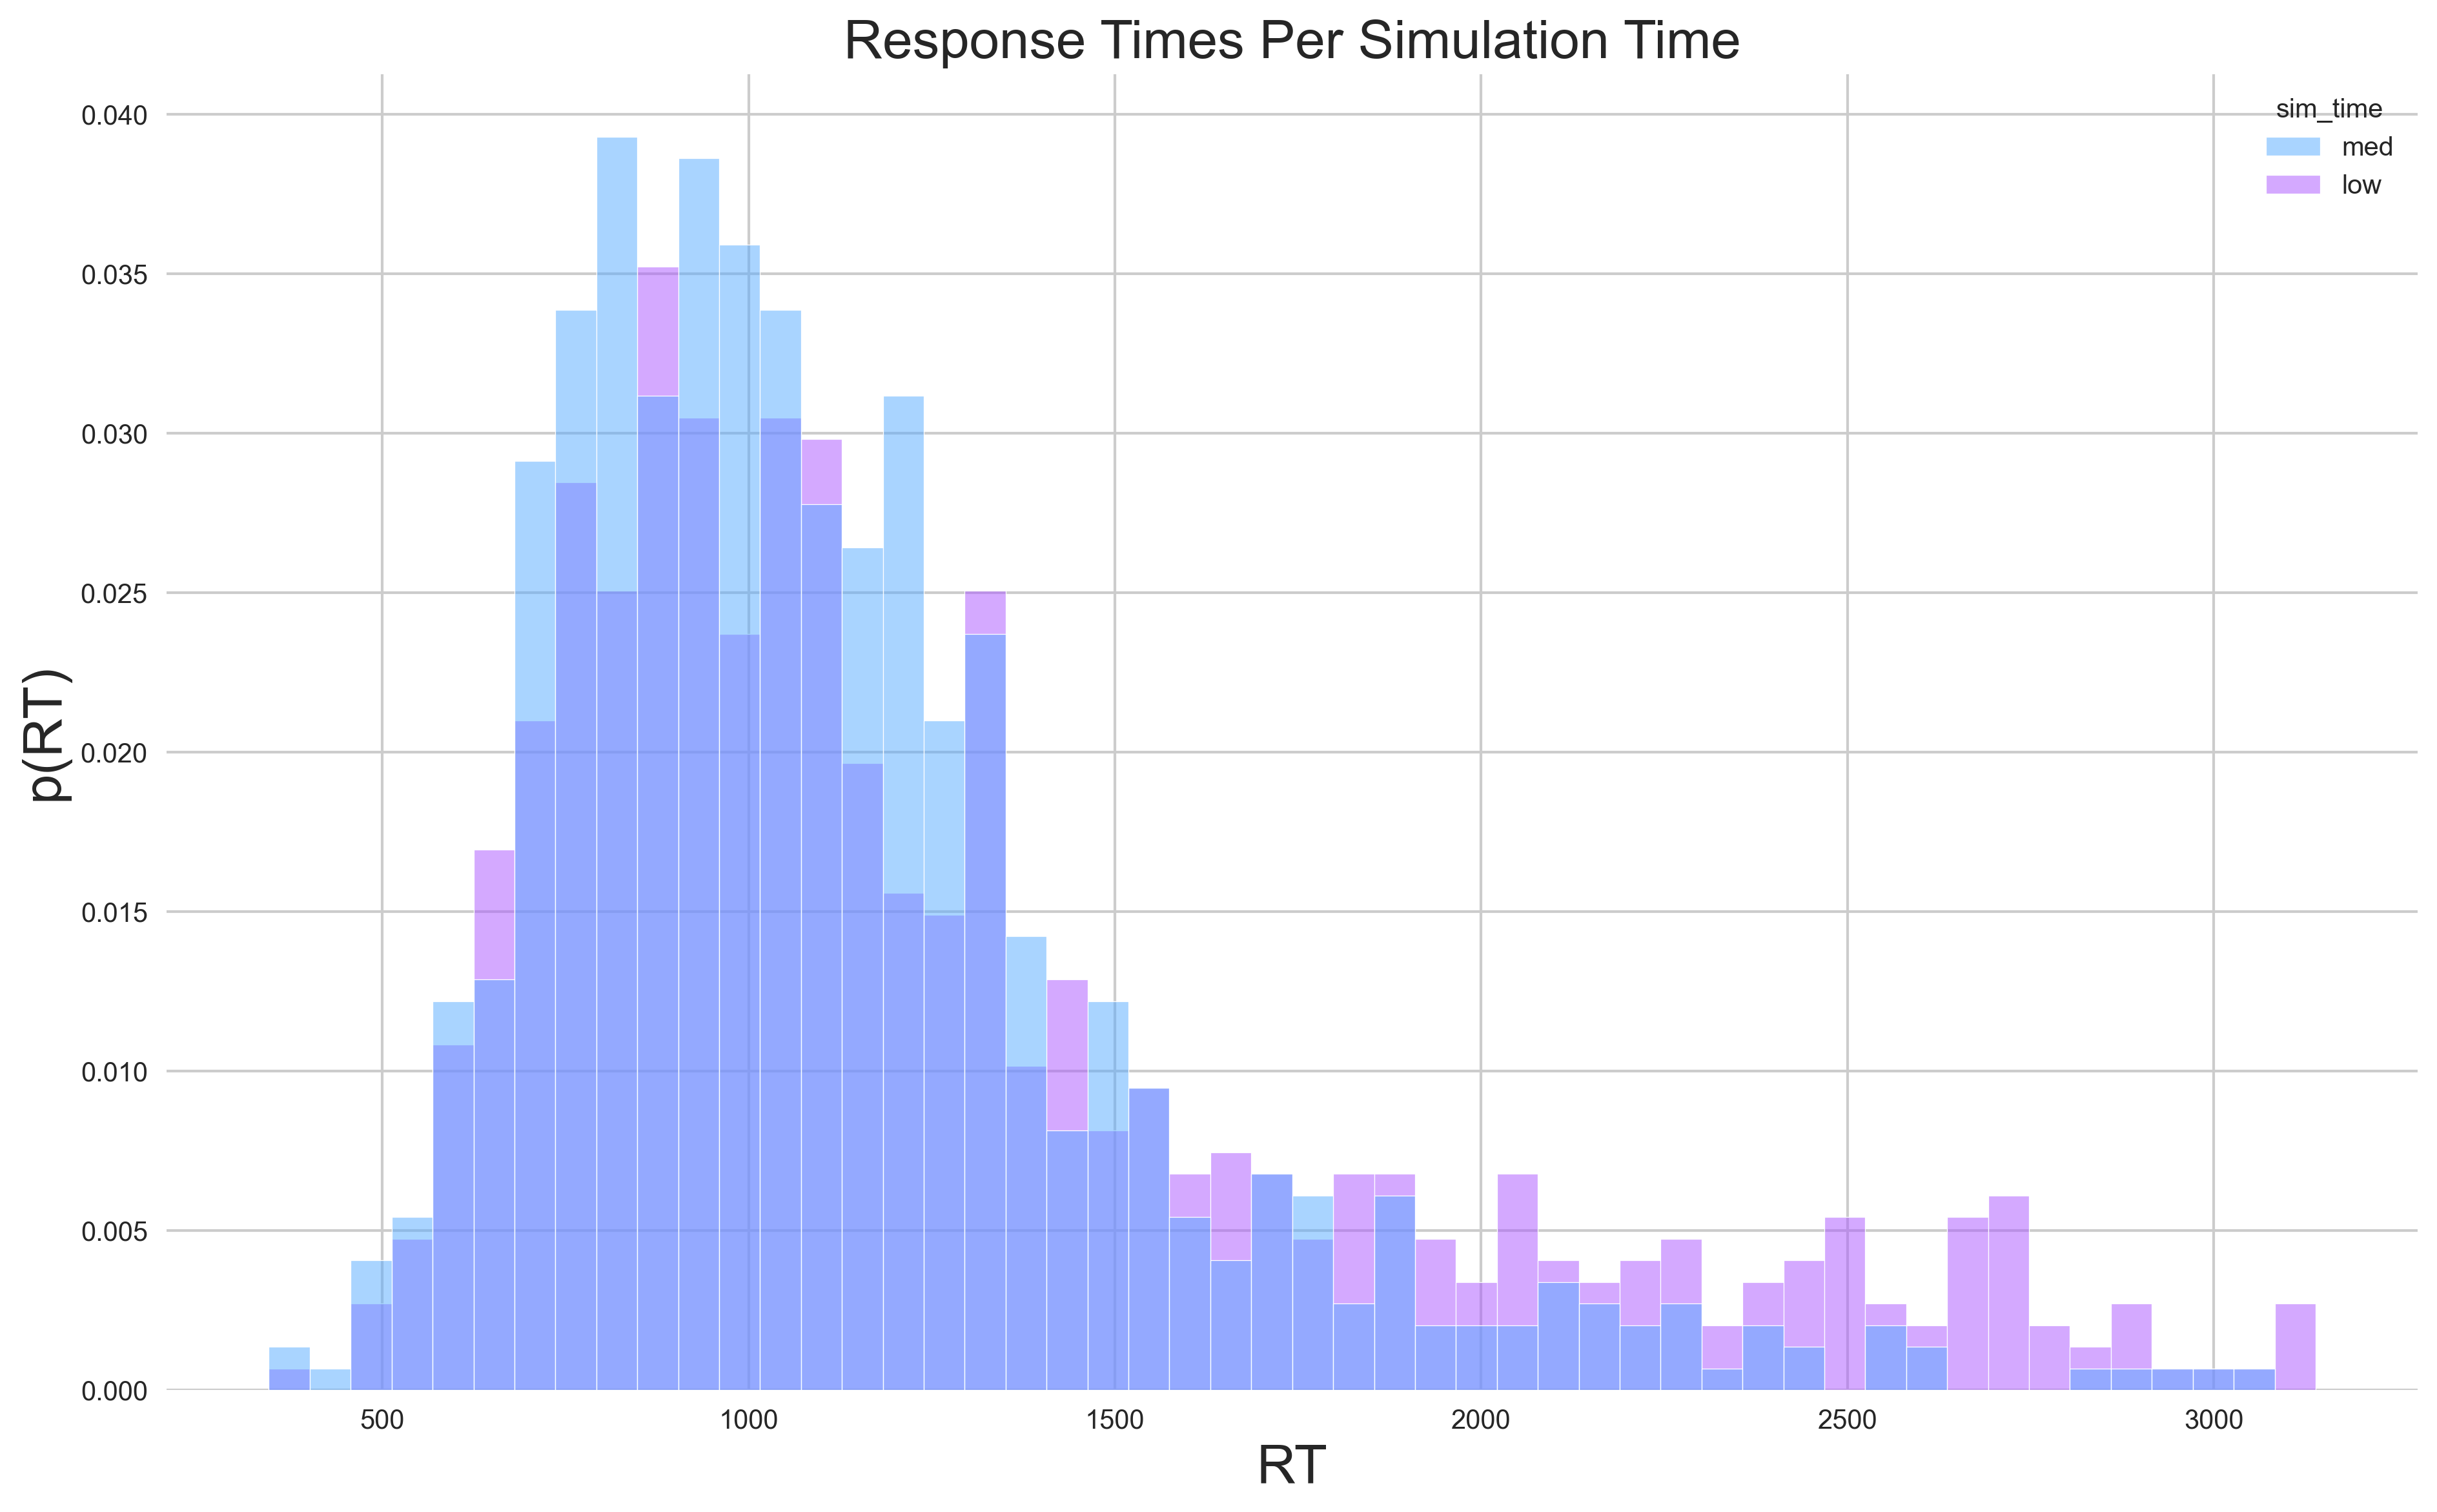

In [755]:
figure(figsize=(15, 9), dpi=300)
df = clean_responses[(clean_responses.sim_time == "med") & (clean_responses.collision == "yes")]
df = pd.concat([df, clean_responses[(clean_responses.sim_time == "low")]])
sns.histplot(x="rt",data=df,hue="sim_time",bins=50,stat="probability",palette="cool")
plt.title("Response Times Per Simulation Time",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("p(RT)",fontsize=20);

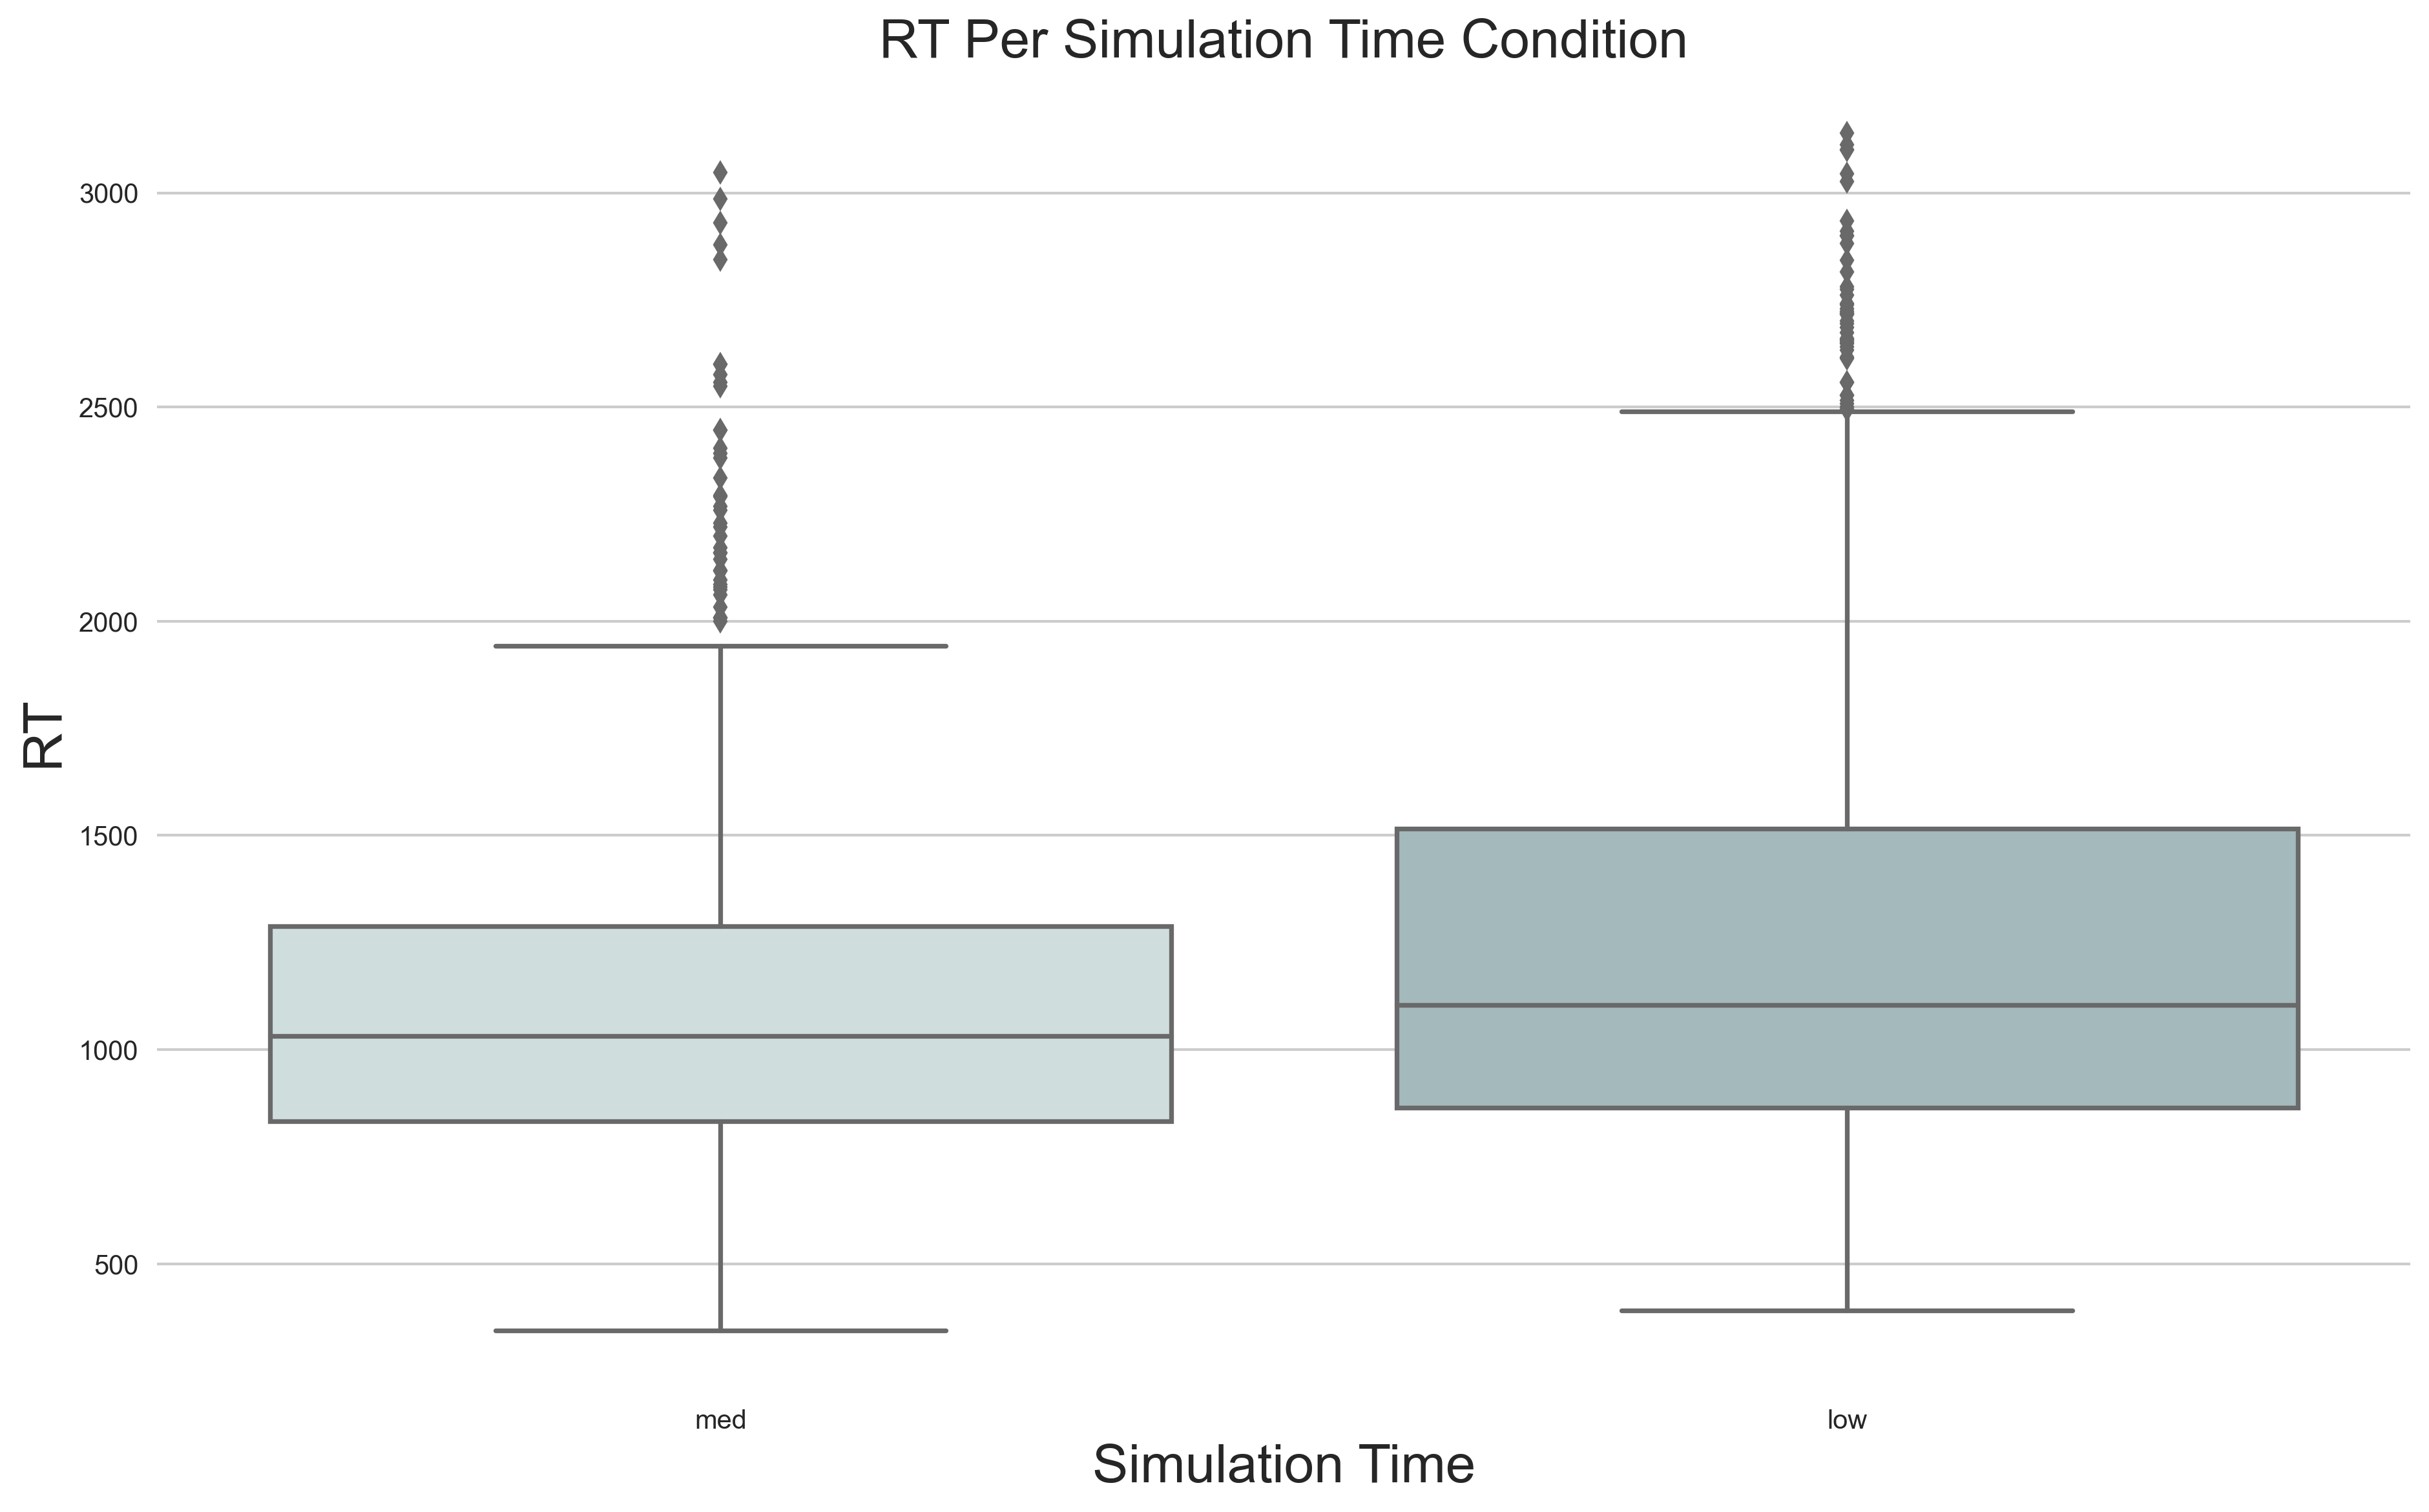

In [756]:
figure(figsize=(15, 9), dpi=300)
sns.boxplot(y="rt",x="sim_time",data=df)
plt.title("RT Per Simulation Time Condition",fontsize=20)
plt.xlabel("Simulation Time",fontsize=20)
plt.ylabel("RT",fontsize=20)
plt.show()

## Calculating Empirical 95% CI

In [539]:
low = list(clean_responses[(clean_responses["sim_time"]=="low")].rt)
med = list(clean_responses[(clean_responses["sim_time"]=="med")].rt)
high = list(clean_responses[(clean_responses["sim_time"]=="high")].rt)

def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

low_bs_samples = draw_bs_replicates(low,np.mean,1000)
med_bs_samples = draw_bs_replicates(med,np.mean,1000)
high_bs_samples = draw_bs_replicates(high,np.mean,1000)

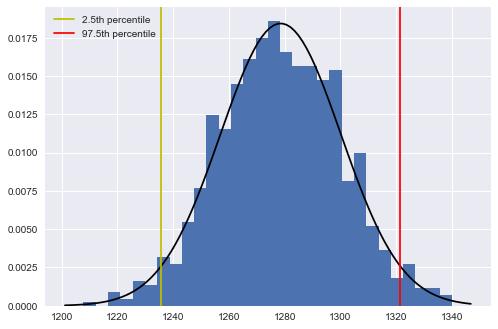

In [543]:
from scipy.stats import norm

# Plot the PDF for bootstrap replicates as histogram
plt.hist(low_bs_samples,bins=30,density=True)

mu, std = np.mean(low_bs_samples), np.std(low_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(low_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(low_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

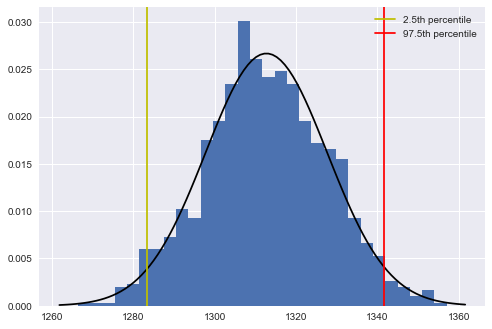

In [545]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(med_bs_samples,bins=30,density=True)

mu, std = np.mean(med_bs_samples), np.std(med_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(med_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(med_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

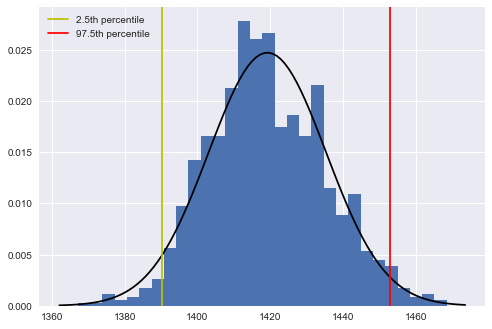

In [546]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(high_bs_samples,bins=30,density=True)

mu, std = np.mean(high_bs_samples), np.std(high_bs_samples)
xmin, xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = norm.pdf(x,mu,std)

plt.plot(x,p,'k')

# Showing the related percentiles
plt.axvline(x=np.percentile(high_bs_samples,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(high_bs_samples,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')

plt.legend()

Text(0, 0.5, 'P(RT)')

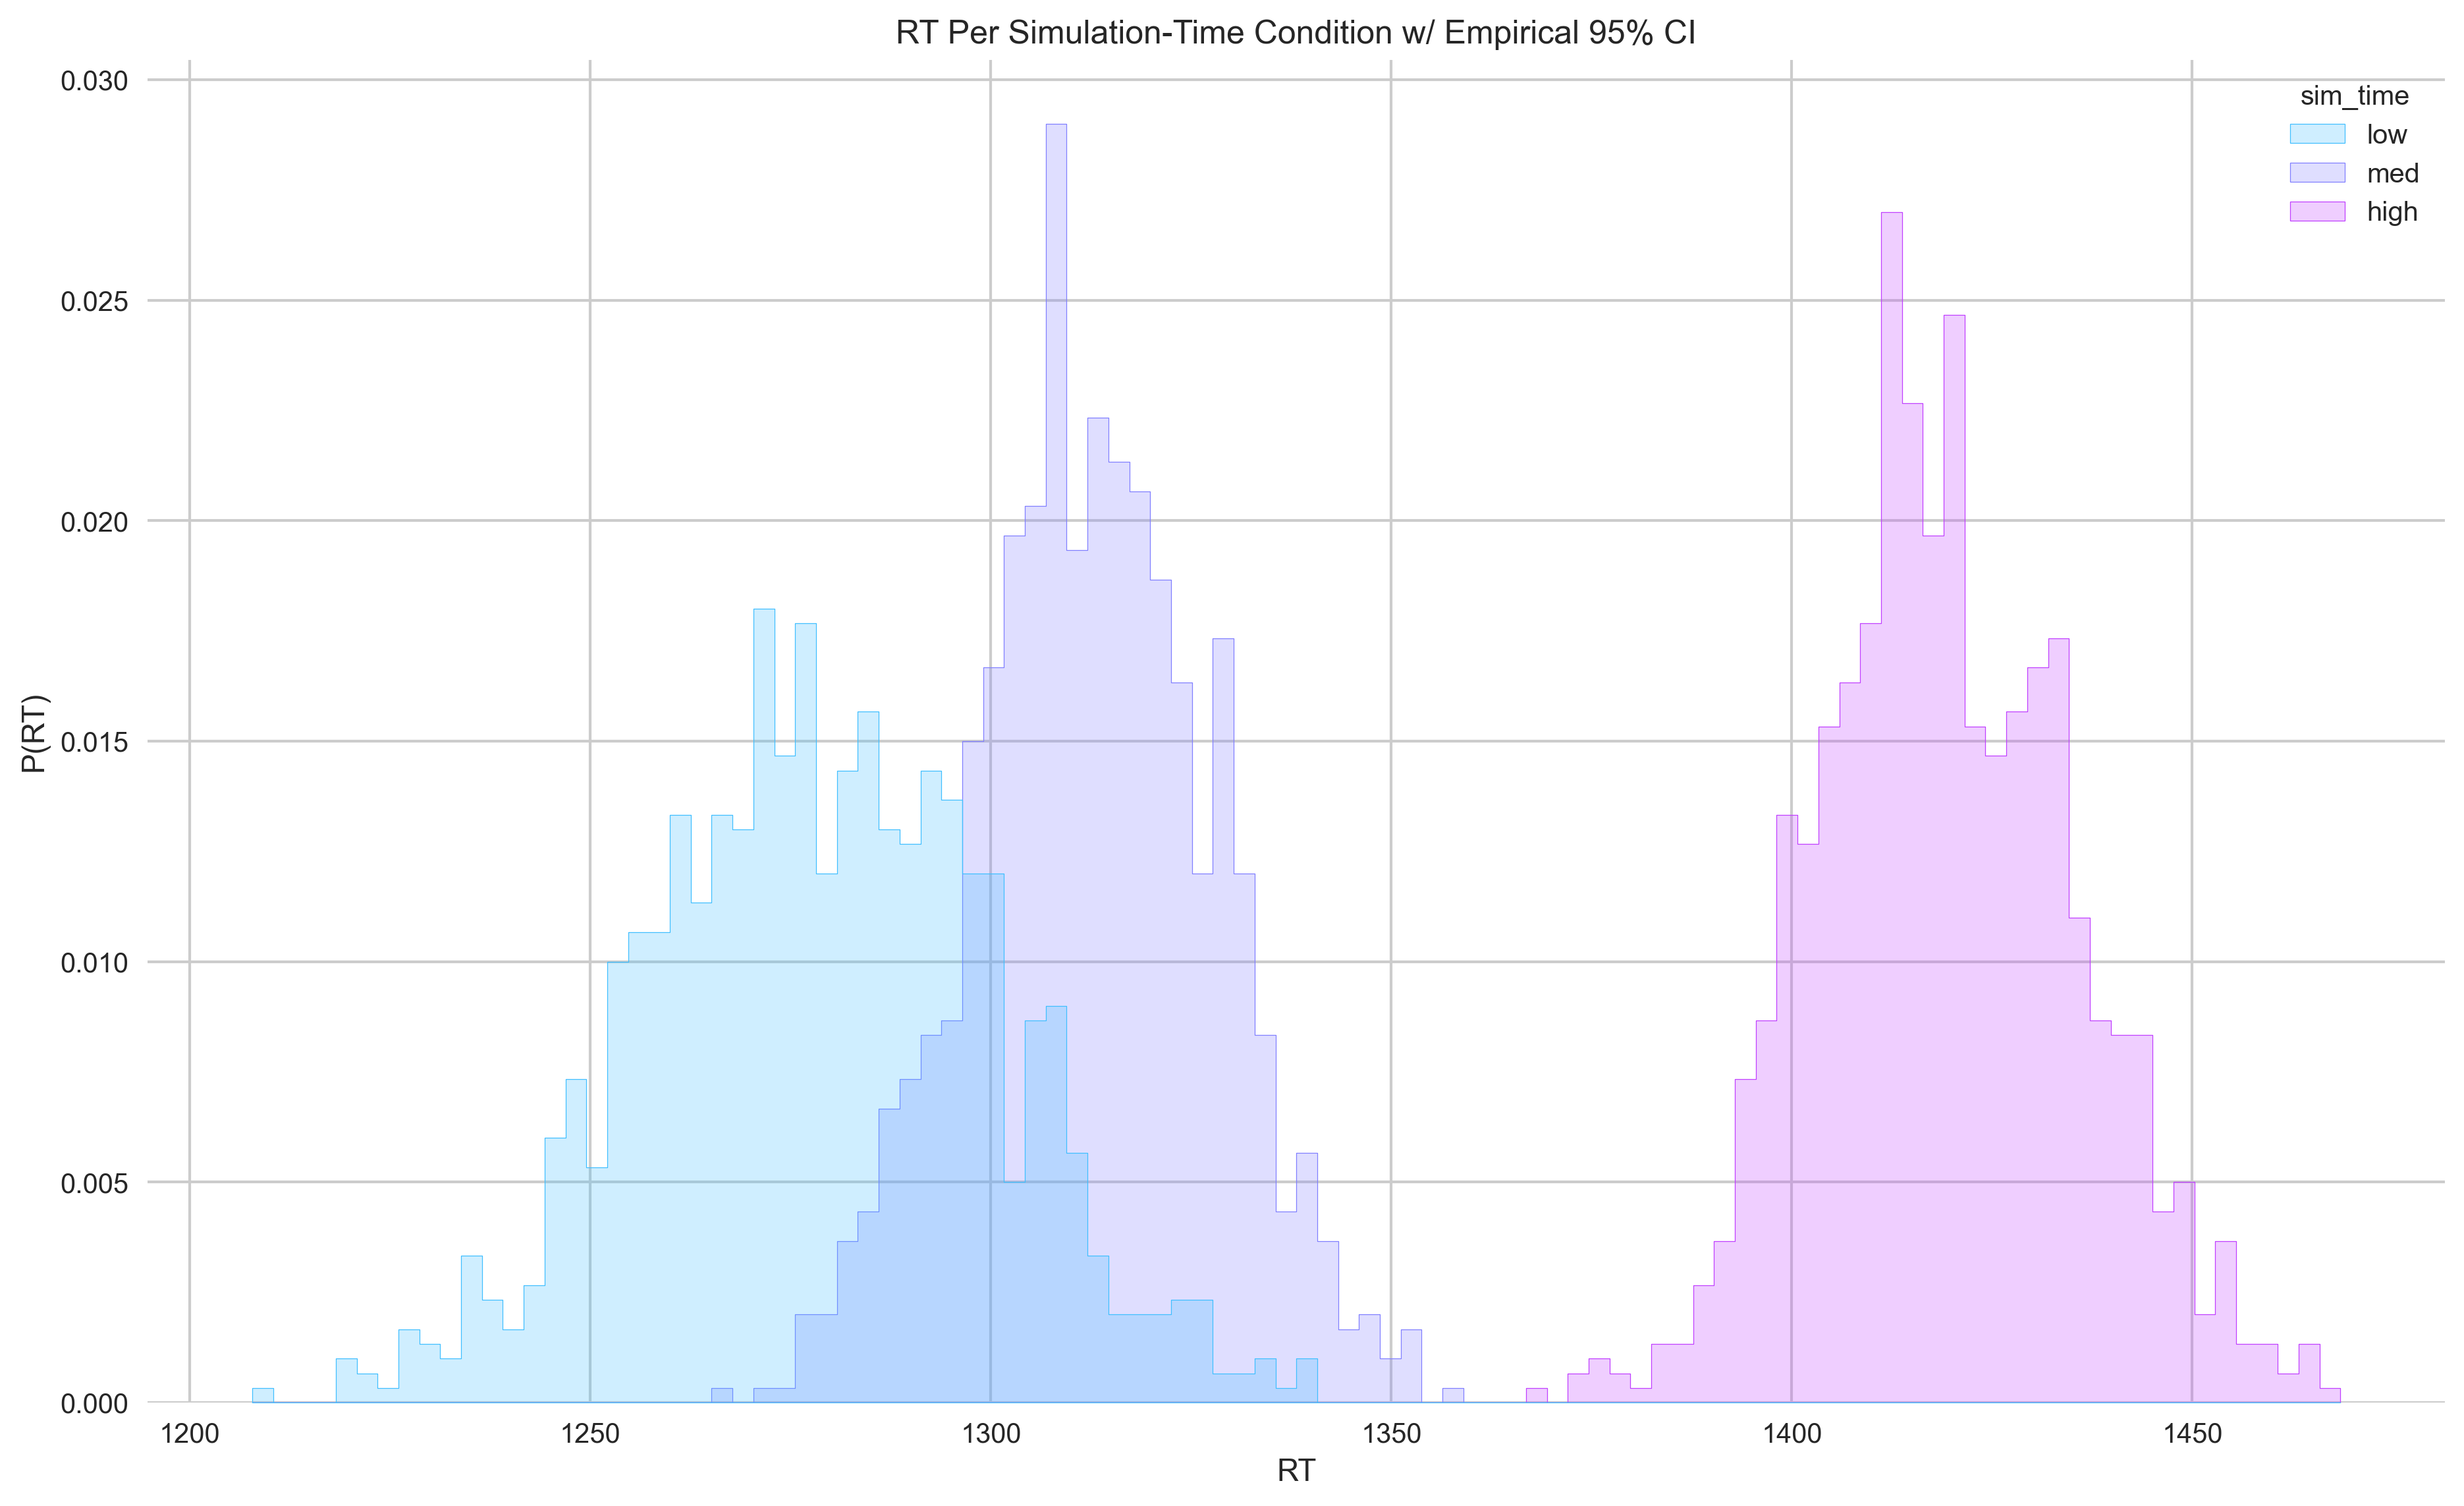

In [719]:
low_d = {'rt': low_bs_samples,'sim_time':["low"]*len(low_bs_samples)}
med_d = {'rt': med_bs_samples,'sim_time':["med"]*len(med_bs_samples)}
high_d = {'rt': high_bs_samples,'sim_time':["high"]*len(high_bs_samples)}

df = pd.DataFrame([low_d,med_d,high_d])
df = df.explode("rt")
df['sim_time'] = df.sim_time.apply(lambda x: x[0])

sns.histplot(x="rt",data=df,hue="sim_time",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Simulation-Time Condition w/ Empirical 95% CI")
plt.xlabel("RT")
plt.ylabel("P(RT)")

# RT for scenes that are "obvious"

#### Conclusions
1. Obvious scenes have significantly lower RT, RT(Obv) < RT(NotObv) (MWU, p = 3e-32)
2. The relation is preserved within simulation time conditions RT(ObvMed) < RT(ObvHigh) (MWU, p = 4.4e-7) 

Text(0, 0.5, 'P(RT)')

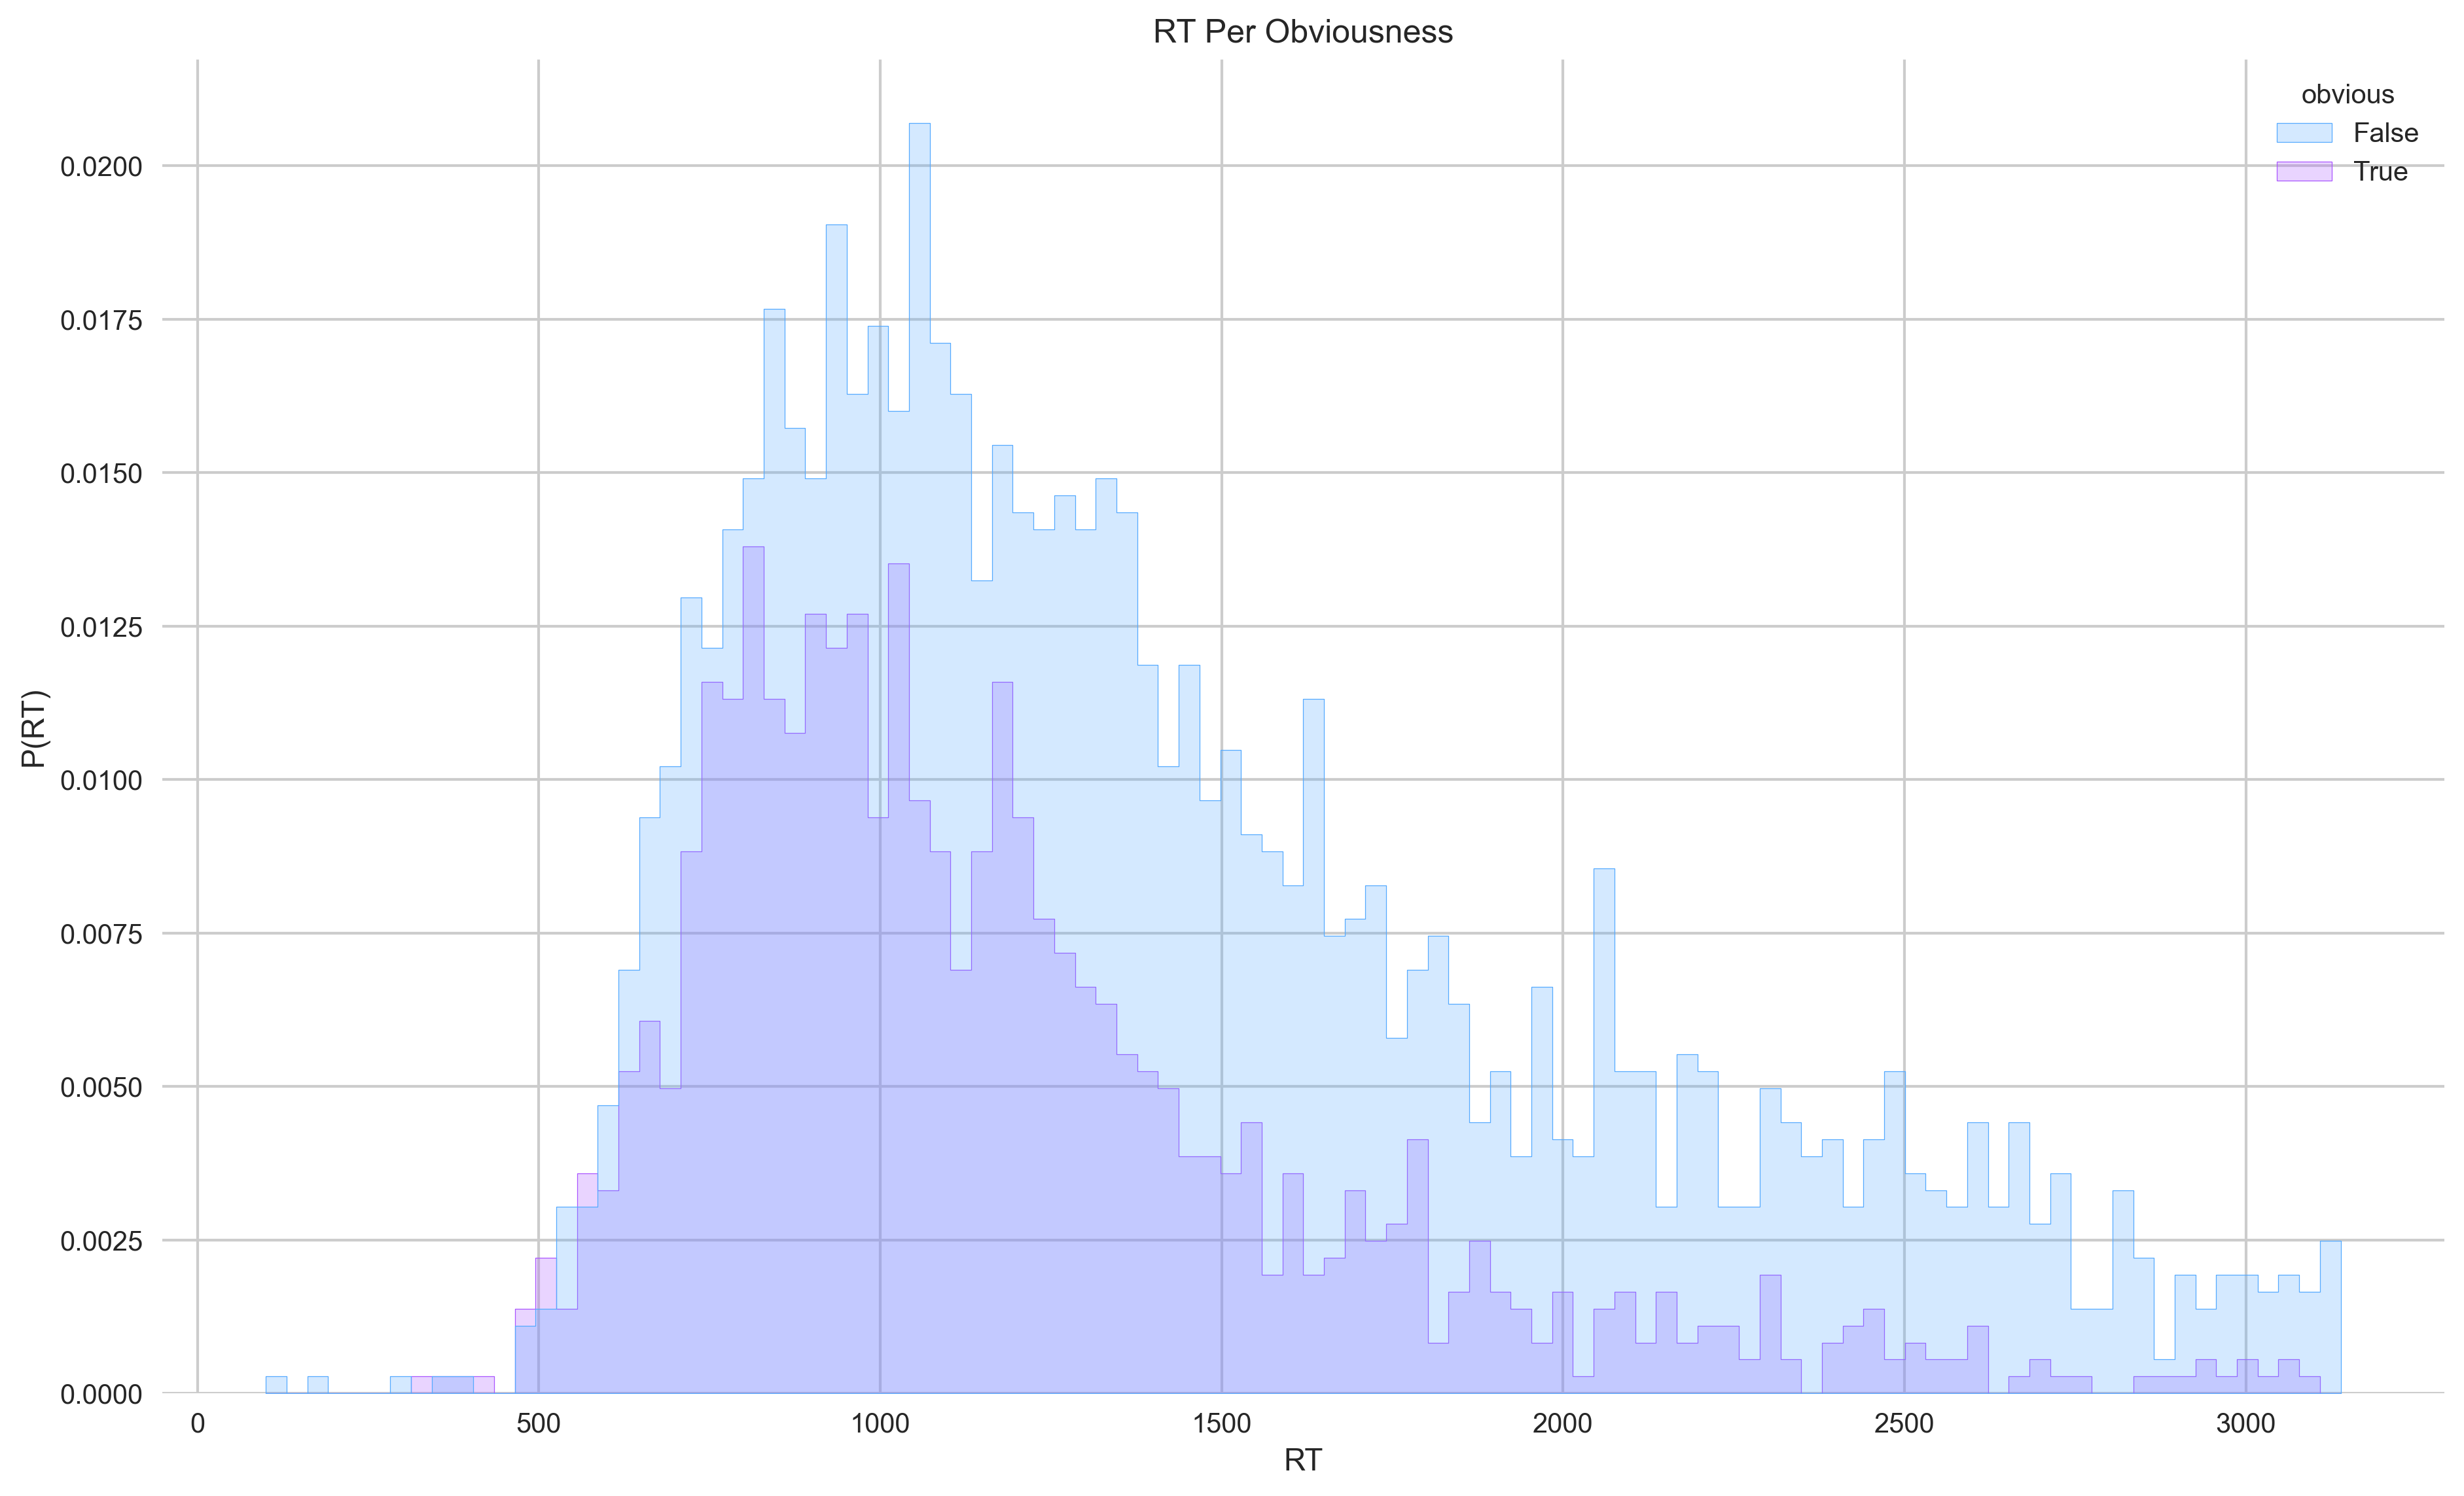

In [777]:
sns.histplot(x="rt",data=clean_responses,hue="obvious",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Obviousness")
plt.xlabel("RT")
plt.ylabel("P(RT)")

In [779]:
# RT for medium-no condition
obvious = list(clean_responses[(clean_responses["obvious"]==True)].rt)
not_obvious = list(clean_responses[(clean_responses["obvious"]==False)].rt)
u_res = mannwhitneyu(obvious, not_obvious, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=1099575.0, pvalue=3.436837783705006e-32)


## RT per obviousness and simulation time condition

Text(0, 0.5, 'P(RT)')

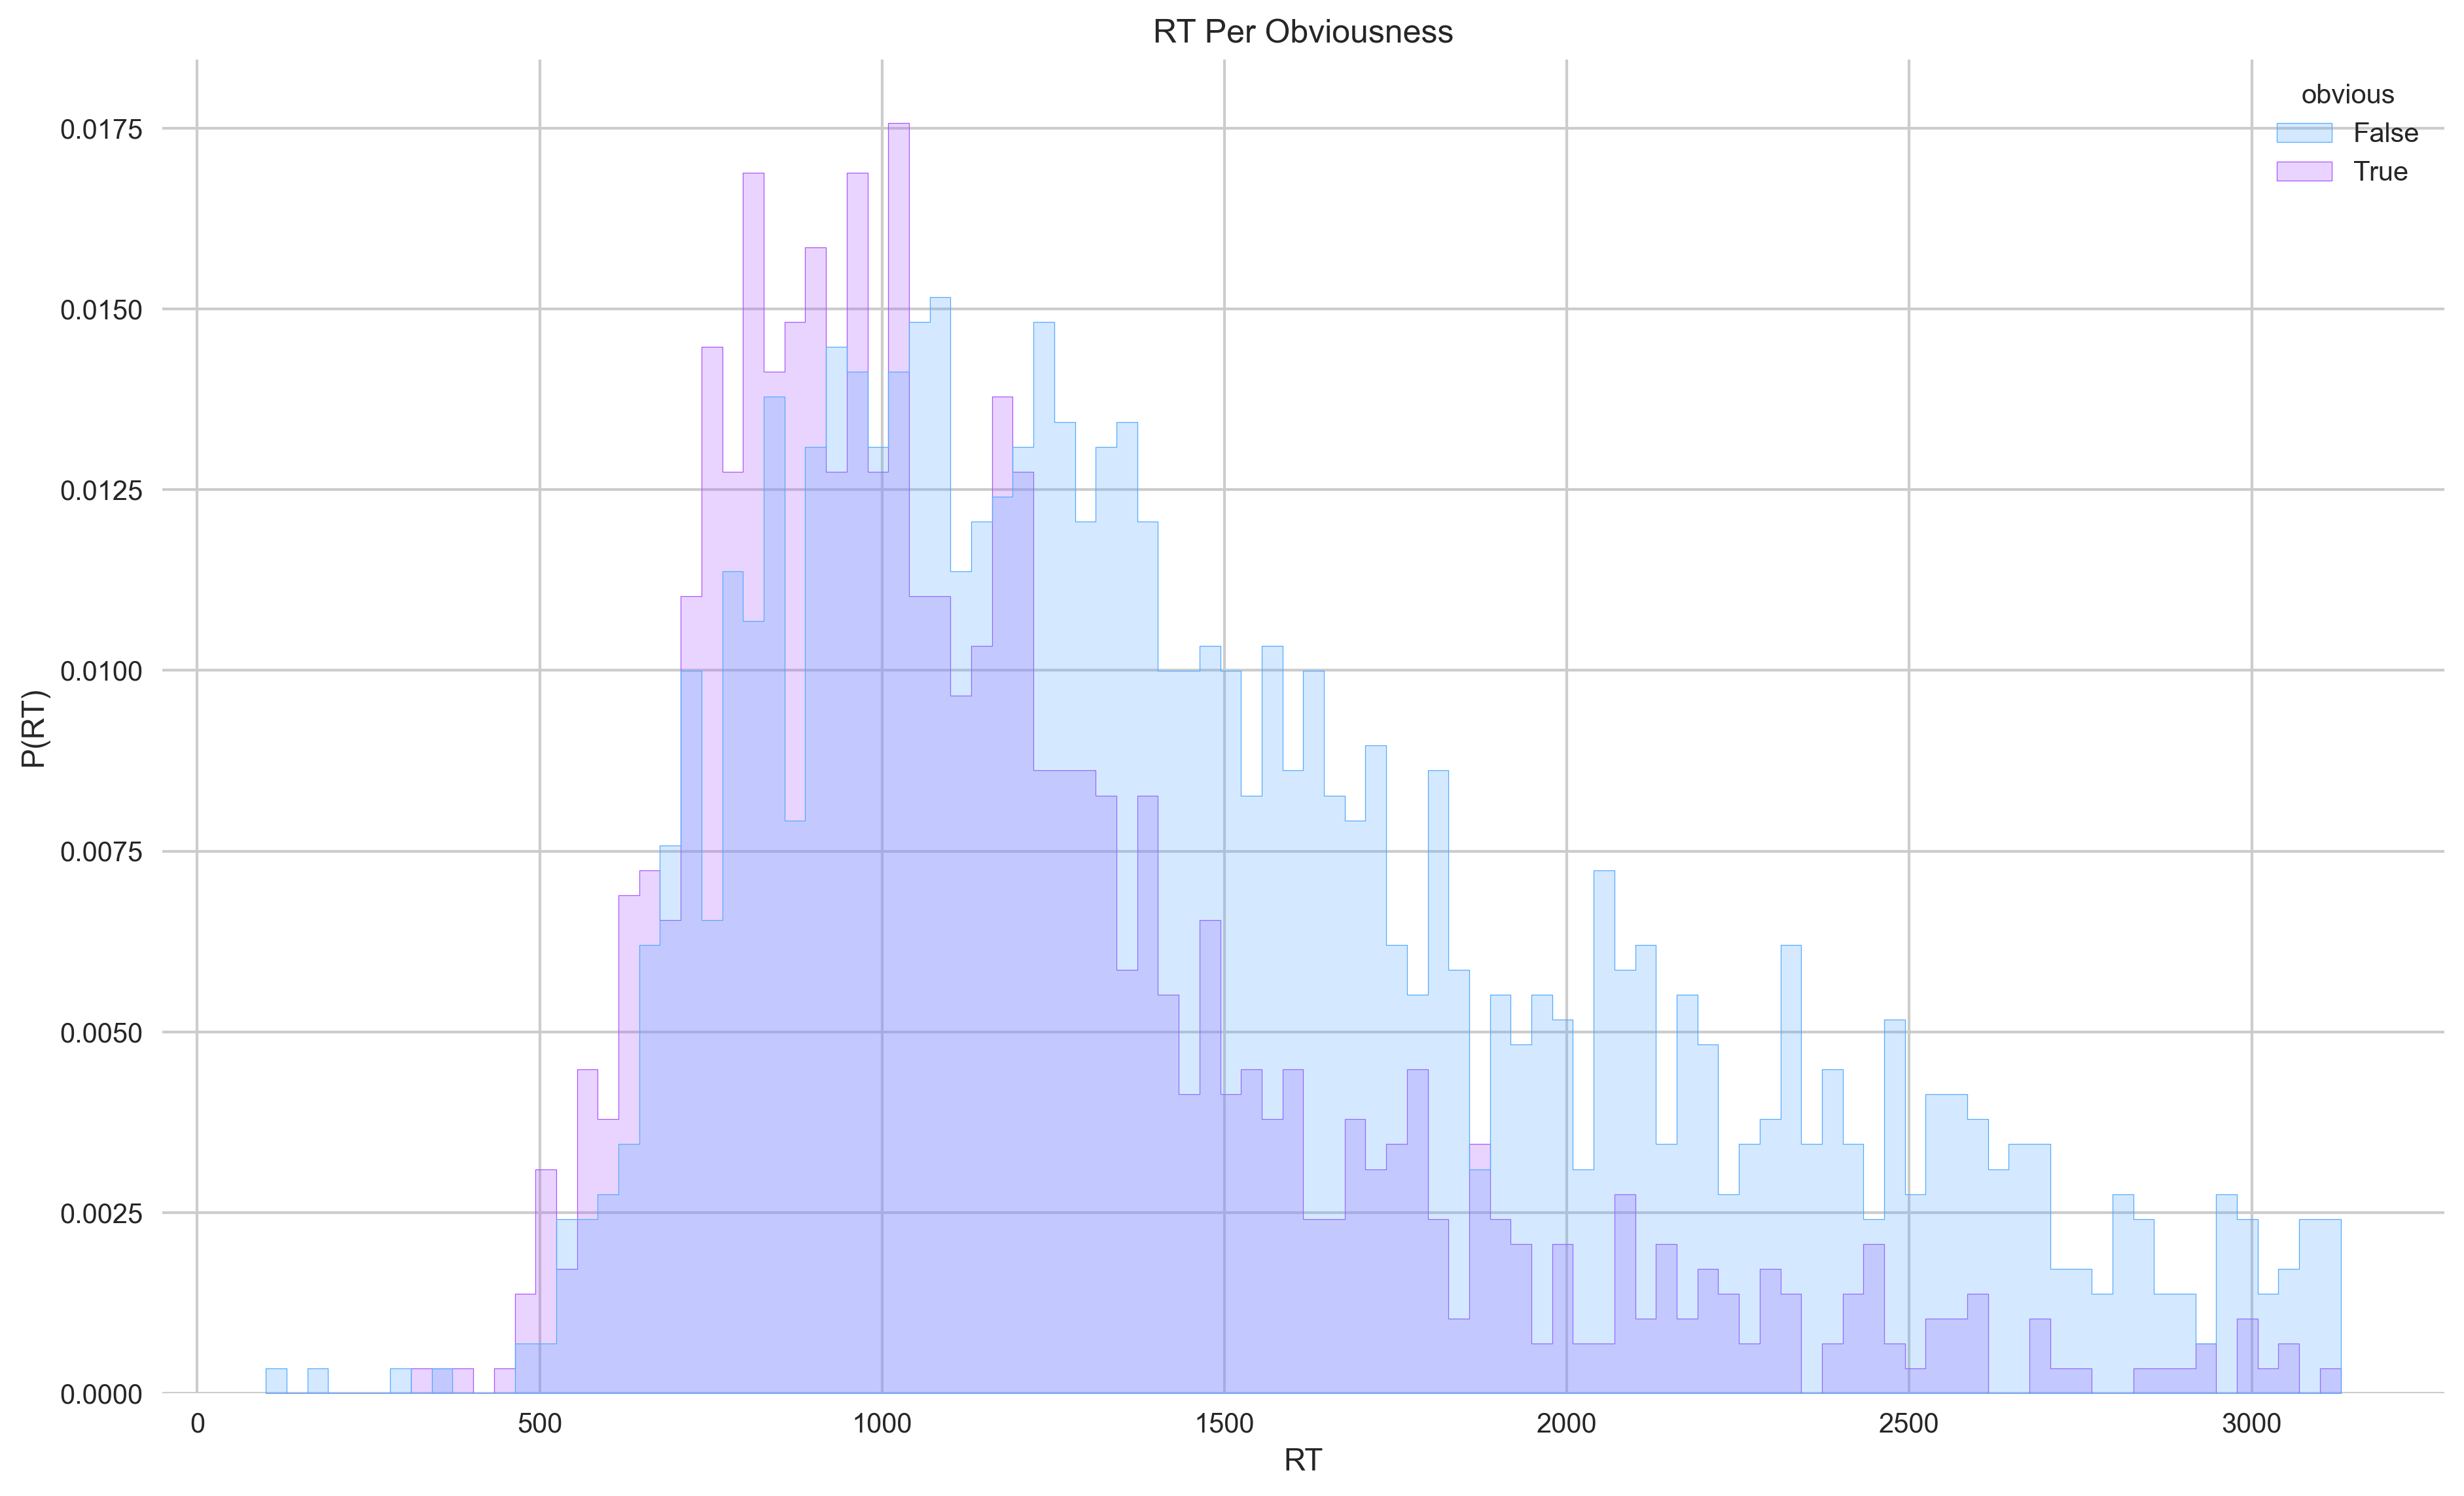

In [782]:
df = clean_responses[(clean_responses.sim_time == "med") | (clean_responses.sim_time == "high")]
sns.histplot(x="rt",data=df,hue="obvious",bins=100,element="step",palette="cool",stat="probability")

plt.title("RT Per Obviousness")
plt.xlabel("RT")
plt.ylabel("P(RT)")

In [785]:
# RT for medium-no condition
med_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="med")].rt)
high_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="high")].rt)
u_res = mannwhitneyu(med_obvious, high_obvious, alternative="less")
print(f"U test statistic: {u_res}")

U test statistic: MannwhitneyuResult(statistic=135819.5, pvalue=4.447719945054231e-07)


In [ ]:
med_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="med")].rt)
low_obvious = list(clean_responses[(clean_responses["obvious"]==True) & (clean_responses["sim_time"]=="low")].rt)
u_res = mannwhitneyu(med_obvious, high_obvious, alternative="less")
print(f"U test statistic: {u_res}")

# Model

In [849]:
model = pd.read_json("model_outputs.json")

In [850]:
sprt = model['sprt'].apply(pd.Series)
sprt["model"] = 'sprt'
sprt = sprt.rename(columns={'probchoice':'p_sprt','samples': 'rt_sprt'})

det = model['deterministic'].apply(pd.Series)
det["model"] = 'deterministic'
det = det.rename(columns={'probchoice':'p_det','samples': 'rt_det'})

stoch = model['stochastic'].apply(pd.Series)
stoch["model"] = 'stochastic'
stoch = stoch.rename(columns={'probchoice':'p_stoch','samples': 'rt_stoch'})

abst = model['abstraction'].apply(pd.Series)
abst["model"] = 'abstraction'
abst = abst.rename(columns={'probchoice':'p_abs','samples': 'rt_abs'})

In [851]:
model = pd.concat([sprt,det,stoch,abst])
model

,scene,p_sprt,rt_sprt,model,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
0,med_no14,0.0,1374.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
1,high_yes14,1.0,806.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
2,low_no6,0.0,672.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
3,med_yes10,1.0,806.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
4,high_yes6,1.0,808.0,sprt,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
70,low_no5,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,209.0
71,med_yes13,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,205.0
72,high_yes5,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,365.0
73,med_no1,NaN,NaN,abstraction,NaN,NaN,NaN,NaN,0.0,323.0


In [852]:
model = model.apply(lambda x: pd.Series(x.dropna().values))

In [853]:
model = model.iloc[0:75]
model.drop(['model'], axis=1)

,scene,p_sprt,rt_sprt,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
0,med_no14,0.0,1374.0,0.0,337.0,0.00,345.28,0.0,346.0
1,high_yes14,1.0,806.0,1.0,201.0,0.90,260.08,0.0,345.0
2,low_no6,0.0,672.0,0.0,171.0,0.00,167.45,0.0,181.0
3,med_yes10,1.0,806.0,1.0,201.0,0.99,201.89,1.0,2.0
4,high_yes6,1.0,808.0,1.0,201.0,0.71,231.90,1.0,2.0
...,...,...,...,...,...,...,...,...,...
70,low_no5,0.0,734.0,0.0,184.0,0.00,176.64,0.0,209.0
71,med_yes13,1.0,956.0,1.0,275.0,0.97,244.77,0.0,205.0
72,high_yes5,1.0,6924.0,1.0,409.0,0.77,414.04,0.0,365.0
73,med_no1,0.0,1302.0,0.0,303.0,0.01,321.06,0.0,323.0


In [861]:
clean_responses = clean_responses.merge(model, on="scene")

In [884]:
clean_responses.corr()

,trial_index,rt,scene_index,zrt,log_rt,zlogrt,participant_accuracy,trial_accuracy,scene_accuracy,obvious,p_sprt,rt_sprt,p_det,rt_det,p_stoch,rt_stoch,p_abs,rt_abs
trial_index,1.000000,-0.113028,-0.005618,-0.113028,-0.106890,-0.106890,-0.001907,0.110222,0.001598,-0.001382,-0.006407,0.004729,-0.002465,-0.010462,-0.004062,-0.005245,0.001832,-0.014808
rt,-0.113028,1.000000,0.081537,1.000000,0.970077,0.970077,-0.098264,-0.040360,-0.151759,-0.197063,-0.155311,0.153265,-0.134986,0.208694,-0.161696,0.225436,-0.220221,0.220682
scene_index,-0.005618,0.081537,1.000000,0.081537,0.092338,0.092338,-0.002920,-0.032856,-0.380389,0.105101,0.274009,0.352221,0.338498,0.495940,0.263625,0.643568,0.059916,0.398819
zrt,-0.113028,1.000000,0.081537,1.000000,0.970077,0.970077,-0.098264,-0.040360,-0.151759,-0.197063,-0.155311,0.153265,-0.134986,0.208694,-0.161696,0.225436,-0.220221,0.220682
log_rt,-0.106890,0.970077,0.092338,0.970077,1.000000,1.000000,-0.099067,-0.043258,-0.159459,-0.194096,-0.147927,0.159085,-0.129031,0.204736,-0.154256,0.227668,-0.220610,0.225530
zlogrt,-0.106890,0.970077,0.092338,0.970077,1.000000,1.000000,-0.099067,-0.043258,-0.159459,-0.194096,-0.147927,0.159085,-0.129031,0.204736,-0.154256,0.227668,-0.220610,0.225530
participant_accuracy,-0.001907,-0.098264,-0.002920,-0.098264,-0.099067,-0.099067,1.000000,-0.004682,0.006778,-0.006311,-0.008552,0.002386,-0.007306,-0.001213,-0.008827,0.000906,-0.006804,0.003729
trial_accuracy,0.110222,-0.040360,-0.032856,-0.040360,-0.043258,-0.043258,-0.004682,1.000000,0.094912,0.015037,-0.019815,-0.038966,-0.024419,-0.029363,-0.019940,-0.041883,0.027221,-0.034742
scene_accuracy,0.001598,-0.151759,-0.380389,-0.151759,-0.159459,-0.159459,0.006778,0.094912,1.000000,0.184414,-0.224220,-0.270195,-0.297907,-0.356594,-0.231844,-0.429472,0.215717,-0.315937
obvious,-0.001382,-0.197063,0.105101,-0.197063,-0.194096,-0.194096,-0.006311,0.015037,0.184414,1.000000,0.843435,-0.153986,0.760709,-0.383096,0.832665,-0.436783,0.848547,-0.612978


In [881]:
import statsmodels.formula.api as sm
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_sprt + p_sprt", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     38.84
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           6.01e-10
Time:                        14:23:29   Log-Likelihood:                -11271.
No. Observations:                1475   AIC:                         2.255e+04
Df Residuals:                    1473   BIC:                         2.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    575.7026      9.631     59.773      0.0

In [882]:
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_abs + p_abs", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     69.66
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.24e-29
Time:                        14:23:34   Log-Likelihood:                -11224.
No. Observations:                1475   AIC:                         2.245e+04
Df Residuals:                    1472   BIC:                         2.247e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1427.0620    110.692     12.892      0.0

In [883]:
df = clean_responses[clean_responses.collision == "yes"]
result = sm.ols(formula="rt ~ rt_stoch + p_stoch", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     56.89
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.59e-24
Time:                        14:23:37   Log-Likelihood:                -11236.
No. Observations:                1475   AIC:                         2.248e+04
Df Residuals:                    1472   BIC:                         2.249e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1640.3774    201.077      8.158      0.0